# groups_graphs_notebook

For this notebook to work from start to end without the need to change any directories, ensure that the folder FINAL_RNA/ is in our github folder chrisnatjulia/ and this notebook (groups_graphs_notebook.ipynb) is in our github folder chrisnatjulia/scripts/graphs_for_assembly_in_R/

# 1. Load Libraries and set parameters

If you don't have these libraries installed, go to R and install them manually first

In [171]:
library(dplyr)
library(data.table)
library(ggplot2)
library(viridis)
library(vegan)
library(stringr)

Indicate assemblers, classifiers, and mappers you used (**important: in the order they appear in the FINAL_RNA/ folder)**

In [2]:
assemblers <- c("IDBA-tran", "rnaSPAdes", "Trinity")
classifiers <- c("BLAST_nt", "BLAST_SILVA", "CREST")
mappers <- c("Bowtie2", "BWA")

# 2. Read in data and tidy it up

Reading in data from all files within the FINAL_RNA/ folder


In [3]:
files_list_full_path <- list.files("../../FINAL_RNA/", pattern = "\\.txt$", , full.names=T) # For fread to work (needs full path in our case)
files_list_just_names <- list.files("../../FINAL_RNA/", pattern = "\\.txt$") # To make names for the dataframes based on file names
dataframe_names_list <- gsub("\\_final.txt$", "", files_list_just_names)
all_list <- lapply(files_list_full_path, fread) # Creating a list with data frames of all files
names(all_list) <- dataframe_names_list # Changing the names of the dataframes in list
tax_full_dataframes <- lapply(all_list, function(x) x%>% select(superkingdom:genus)) # Creating a list with full taxanomy of each data frame
counts_dataframes <- lapply(all_list, function(x) x%>% select(counts)) # Creating a list with counts of each data frame


Create functions to generate vectors that contain taxonomic groups


In [4]:
# Create function to generate taxlist vector with phylum per row in taxonomy table (or if phylum = NA, then superkingdom: Unkown)
make_tax_phylum_dataframe <- function(tax)
  {
    taxlastrow <- nrow(tax)
    taxlist <- rep(NA,nrow(tax))
    for (i in 1:nrow(tax))
    { if (is.na(tax[i,1]) == TRUE)
      { taxlist[i] <- "NA"
    } else if (tax[i,1] == "Unknown")
      { taxlist[i] <- "Unknown"
    } else if (is.na(tax[i,3]) == TRUE)
      { taxlist[i] <- paste(tax[i,1], ": Unknown", sep="")
    } else
      { taxlist[i] <- paste(tax[i,1], ": ", tax[i,3], sep="") }
    }
    taxdf <- as.data.frame(taxlist)
    return(taxdf)
  }

# Create function to generate taxlist vector with superkingdom per row in taxonomy table
make_tax_superkingdom_dataframe <- function(tax)
{
  taxlastrow <- nrow(tax)
  taxlist <- rep(NA,nrow(tax))
  for (i in 1:nrow(tax))
  { if (is.na(tax[i,1]) == TRUE)
      { taxlist[i] <- "NA"
      } else
      { taxlist[i] <- tax[i,1] }
  }
  taxdf <- t(as.data.frame(taxlist))
  return(taxdf)
}

Apply taxlist fuction to list of dataframes (phylum and superkingdom assignments in separate dataframe lists), **might take a while**


In [5]:
tax_superkingdom_dataframes <- lapply(tax_full_dataframes, make_tax_superkingdom_dataframe)
tax_phylum_dataframes <- lapply(tax_full_dataframes, make_tax_phylum_dataframe)

Combine read count and phylum/superkingdom information and aggregate based on groups


In [6]:
aggregate_tax_groups <- function(group_counts_dataframes)
  {
    setNames(aggregate(unlist(group_counts_dataframes[[2]])~unlist(group_counts_dataframes[[1]]),data=group_counts_dataframes,FUN=sum), c("Group", "Reads"))
  }

phylum_counts_dataframes <- mapply(cbind, tax_phylum_dataframes, counts_dataframes, SIMPLIFY=FALSE)
phylum_agg_dataframes <- lapply(phylum_counts_dataframes, aggregate_tax_groups)

superkingdom_counts_dataframes <- mapply(cbind, tax_superkingdom_dataframes, counts_dataframes, SIMPLIFY=FALSE)
superkingdom_agg_dataframes <- lapply(superkingdom_counts_dataframes, aggregate_tax_groups)

Merge all dataframes in list


In [75]:
# For phyla
merged_phylum <- phylum_agg_dataframes %>%
  Reduce(function(df1,df2) full_join(df1,df2,by="Group"), .) %>% 
  mutate_each(funs(replace(., which(is.na(.)), 0)))
colnames(merged_phylum) <- c("Group", dataframe_names_list)
merged_phylum_ordered <- merged_phylum[order(as.character(merged_phylum$Group)),] # Order groups alphabetically
merged_phylum_ordered$Group <- factor(merged_phylum_ordered$Group, levels=merged_phylum_ordered$Group) # Command to keep order for ggplot2
         
# For superkingdoms
merged_superkingdom <- superkingdom_agg_dataframes %>%
  Reduce(function(df1,df2) full_join(df1,df2,by="Group"), .) %>% 
  mutate_each(funs(replace(., which(is.na(.)), 0)))
colnames(merged_superkingdom) <- c("Group", dataframe_names_list)
merged_superkingdom_ordered <- merged_superkingdom[order(as.character(merged_superkingdom$Group)),] # Order groups alphabetically
merged_superkingdom_ordered$Group <- factor(merged_superkingdom_ordered$Group, levels=merged_superkingdom_ordered$Group) # Command to keep order for ggplot2

Warning message:
“Column `Group` joining factors with different levels, coercing to character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing int

Generate relative abundances (to transform absolute abundances into compositional data)


In [122]:
# For phyla
phylum_relative_abundances_only <- merged_phylum_ordered
phylum_relative_abundances_only[,1] <- NULL # Delete column Group
phylum_relative_abundances_only <- decostand(phylum_relative_abundances_only, "total", 2)
phylum_relative_abundances <- cbind(merged_phylum_ordered$Group, decostand(phylum_relative_abundances_only, "total", 2))
colnames(phylum_relative_abundances) <- c("Group", dataframe_names_list)
#write.csv(phylum_relative_abundances,"../../phylum_relative_abundances.csv", row.names = FALSE) # Uncomment if you want to save data frame
#phylum_relative_abundances$groupSums <- rowSums(select(phylum_relative_abundances, -Group))
#phylum_relative_abundances
phylum_relative_abundances <- phylum_relative_abundances[order(rowSums(select(phylum_relative_abundances, -Group))),] # Order groups based on sum relative abundance
phylum_relative_abundances$Group <- factor(phylum_relative_abundances$Group, levels=phylum_relative_abundances$Group) # Command to keep order for ggplot2
phylum_relative_abundances
#phylum_relative_abundances_ordered$groupSums <- factor(phylum_relative_abundances_ordered$groupSum, levels=phylum_relative_abundances_ordered$groupSum) # Command to keep order for ggplot2
#phylum_relative_abundances <- select(phylum_relative_abundances_ordered,-groupSums)

# For superkingdoms
superkingdom_relative_abundances_only <- merged_superkingdom_ordered
superkingdom_relative_abundances_only[,1] <- NULL # Delete column Group
superkingdom_relative_abundances_only <- decostand(superkingdom_relative_abundances_only, "total", 2)
superkingdom_relative_abundances <- cbind(merged_superkingdom_ordered$Group, decostand(superkingdom_relative_abundances_only, "total", 2))
colnames(superkingdom_relative_abundances) <- c("Group", dataframe_names_list)
#write.csv(superkingdom_relative_abundances,"../../superkingdom_relative_abundances.csv", row.names = FALSE) # Uncomment if you want to save data frame
#superkingdom_relative_abundances$groupSums <- rowSums(select(superkingdom_relative_abundances, -Group))

Group                                     idba_tran_BLAST_nt_BOWTIE2
116 Bacteria: Candidatus Bipolaricaulota      0.000000e+00              
123 Archaea: Nanoarchaeota                    0.000000e+00              
120 Eukaryota: Parabasalia                    0.000000e+00              
117 Bacteria: Candidatus Hydrogenedentes      0.000000e+00              
93  Bacteria: Candidatus Yanofskybacteria     0.000000e+00              
122 Eukaryota: Onychophora                    0.000000e+00              
11  Bacteria: Candidatus Campbellbacteria     4.383918e-07              
79  Bacteria: Candidatus Hydrothermae         0.000000e+00              
72  Bacteria: Aquificae                       0.000000e+00              
86  Bacteria: Candidatus Margulisbacteria     0.000000e+00              
75  Bacteria: Candidatus Brennerbacteria      0.000000e+00              
9   Bacteria: candidate division NC10         1.315175e-06              
91  Bacteria: Candidatus Peregrinibacteria    0.000000e+00              
76  Bacteria: Candidatus Collierbacteria      0.000000e+00              
125 Bacteria: Candidatus Cloacimonetes        0.000000e+00              
74  Bacteria: Candidatus Berkelbacteria       0.000000e+00              
69  Archaea: Candidatus Aenigmarchaeota       0.000000e+00              
112 Viruses: Unknown                          0.000000e+00              
113 Bacteria: Caldiserica                     0.000000e+00              
114 Bacteria: candidate division Zixibacteria 0.000000e+00              
88  Bacteria: Candidatus Moranbacteria        0.000000e+00              
101 Eukaryota: Acanthocephala                 0.000000e+00              
108 Eukaryota: Gnathostomulida                0.000000e+00              
118 Bacteria: Candidatus Kryptonia            0.000000e+00              
19  Bacteria: Deinococcus-Thermus             2.045828e-06              
109 Eukaryota: Hemimastigophora               0.000000e+00              
115 Bacteria: Candidatus Beckwithbacteria     0.000000e+00              
105 Eukaryota: Nemertea                       0.000000e+00              
99  Bacteria: Kiritimatiellaeota              0.000000e+00              
121 Eukaryota: Brachiopoda                    0.000000e+00              
⋮   ⋮                                         ⋮                         
31  Eukaryota: Annelida                       1.049437e-03              
62  Eukaryota: Streptophyta                   5.448480e-03              
55  Eukaryota: Nematoda                       2.947966e-03              
54  Eukaryota: Mucoromycota                   1.935938e-03              
33  Eukaryota: Arthropoda                     2.684711e-03              
32  Eukaryota: Apicomplexa                    5.056192e-03              
40  Eukaryota: Chytridiomycota                6.821450e-03              
50  Eukaryota: Haptista                       1.503465e-03              
44  Eukaryota: Discosea                       4.233038e-03              
67  NA                                        2.354763e-02              
36  Eukaryota: Basidiomycota                  1.261297e-02              
46  Eukaryota: Euglenozoa                     1.057810e-02              
52  Eukaryota: Imbricatea                     8.005692e-03              
47  Eukaryota: Evosea                         1.158531e-02              
51  Eukaryota: Heterolobosea                  4.595807e-03              
68  Unknown                                   1.395547e-05              
20  Bacteria: Firmicutes                      1.350466e-02              
24  Bacteria: Planctomycetes                  5.582774e-03              
7   Bacteria: Armatimonadetes                 6.613287e-03              
34  Eukaryota: Ascomycota                     3.122899e-02              
41  Eukaryota: Ciliophora                     5.586646e-03              
63  Eukaryota: Tubulinea                      1.330234e-02              
6   Bacteria: Actinobacteria                  2.150860e-02    

# 3. Prepare data for plotting

Transform ("melt") dataset to be able to generate stacked barplots


In [123]:
phylum_melted <- reshape2::melt(phylum_relative_abundances,id.vars = "Group", variable.name="Combination", value.name="Reads")
superkingdom_melted <- reshape2::melt(superkingdom_relative_abundances,id.vars = "Group", variable.name="Combination", value.name="Reads")

Generate Assembler, Classifier, and Mapper columns for the different combinations in melted dataset so that the barplots can be grouped by these


In [186]:
number_of_assemblers <- length(assemblers)
number_of_classifiers <- length(classifiers)
number_of_mappers <- length(mappers)

# Generate assembler column
make_assembler_column <- function(groups_melted)
{
    assembler_column <- NULL 
    for (i in 1:number_of_assemblers) 
    {
      loopresult <- rep(assemblers[i], nrow(groups_melted)/number_of_assemblers)
      assembler_column <- c(assembler_column,loopresult)
    }
return(assembler_column)
}

# Generate classifier column
make_classifier_column <- function(groups_melted)
{
    classifier_column <- NULL
    rep_classifier <- 1
    while (rep_classifier<number_of_assemblers+1)
    {
      for (i in 1:number_of_classifiers) 
      {
        loopresults <- rep(classifiers[i], nrow(groups_melted)/number_of_assemblers/number_of_classifiers)
        classifier_column <- c(classifier_column,loopresults)
      }
    rep_classifier <- rep_classifier+1
    }
return(classifier_column)
}

# Generate mapper column
make_mapper_column <- function(groups_melted)
{
    mapper_column <- NULL
    rep_mapper <- 1
    while (rep_mapper<number_of_assemblers*number_of_classifiers+1)
    {
      for (i in 1:number_of_mappers)
      {
        loopresults <- rep(mappers[i], nrow(groups_melted)/number_of_assemblers/number_of_classifiers/number_of_mappers)
        mapper_column <- c(mapper_column,loopresults)
      }
      rep_mapper <- rep_mapper+1
    }
return(mapper_column)
}

# Generate colour column based on superkingdom
superkingdom_viridis_colors <- viridis_pal(option = "D")(nrow(superkingdom_relative_abundances))
names(superkingdom_viridis_colors) <- superkingdom_relative_abundances$Group
make_colour_column <- function(groups_melted)
{
    colour_column <- NULL
      for (i in 1:nrow(groups_melted))
      {
        loopresults <- superkingdom_viridis_colors[str_extract(phylum_melted$Group[i], "^[^:]+")]
        colour_column <- c(colour_column,loopresults)
      }
return(colour_column)
}
superkingdom_viridis_colors

Archaea    Bacteria   Eukaryota          NA     Unknown     Viruses 
"#440154FF" "#414487FF" "#2A788EFF" "#22A884FF" "#7AD151FF" "#FDE725FF"

Attach new Assembler, Classifier, and Mapper columns to dataframe groups_melted


In [183]:
# For phyla
assembler_column_phylum <- make_assembler_column(phylum_melted)
classifier_column_phylum <- make_classifier_column(phylum_melted)
mapper_column_phylum <- make_mapper_column(phylum_melted)
colour_column_phylum <- make_colour_column(phylum_melted)

phylum_melted$Assembler <- assembler_column_phylum
phylum_melted$Classifier <- classifier_column_phylum
phylum_melted$Mapper <- mapper_column_phylum
phylum_melted$Colour <- colour_column_phylum

# For superkingdoms
assembler_column_superkingdom <- make_assembler_column(superkingdom_melted)
classifier_column_superkingdom <- make_classifier_column(superkingdom_melted)
mapper_column_superkingdom <- make_mapper_column(superkingdom_melted)

superkingdom_melted$Assembler <- assembler_column_superkingdom
superkingdom_melted$Classifier <- classifier_column_superkingdom
superkingdom_melted$Mapper <- mapper_column_superkingdom

Group                                     Combination               
1    Bacteria: Candidatus Bipolaricaulota      idba_tran_BLAST_nt_BOWTIE2
2    Archaea: Nanoarchaeota                    idba_tran_BLAST_nt_BOWTIE2
3    Eukaryota: Parabasalia                    idba_tran_BLAST_nt_BOWTIE2
4    Bacteria: Candidatus Hydrogenedentes      idba_tran_BLAST_nt_BOWTIE2
5    Bacteria: Candidatus Yanofskybacteria     idba_tran_BLAST_nt_BOWTIE2
6    Eukaryota: Onychophora                    idba_tran_BLAST_nt_BOWTIE2
7    Bacteria: Candidatus Campbellbacteria     idba_tran_BLAST_nt_BOWTIE2
8    Bacteria: Candidatus Hydrothermae         idba_tran_BLAST_nt_BOWTIE2
9    Bacteria: Aquificae                       idba_tran_BLAST_nt_BOWTIE2
10   Bacteria: Candidatus Margulisbacteria     idba_tran_BLAST_nt_BOWTIE2
11   Bacteria: Candidatus Brennerbacteria      idba_tran_BLAST_nt_BOWTIE2
12   Bacteria: candidate division NC10         idba_tran_BLAST_nt_BOWTIE2
13   Bacteria: Candidatus Peregrinibacteria    idba_tran_BLAST_nt_BOWTIE2
14   Bacteria: Candidatus Collierbacteria      idba_tran_BLAST_nt_BOWTIE2
15   Bacteria: Candidatus Cloacimonetes        idba_tran_BLAST_nt_BOWTIE2
16   Bacteria: Candidatus Berkelbacteria       idba_tran_BLAST_nt_BOWTIE2
17   Archaea: Candidatus Aenigmarchaeota       idba_tran_BLAST_nt_BOWTIE2
18   Viruses: Unknown                          idba_tran_BLAST_nt_BOWTIE2
19   Bacteria: Caldiserica                     idba_tran_BLAST_nt_BOWTIE2
20   Bacteria: candidate division Zixibacteria idba_tran_BLAST_nt_BOWTIE2
21   Bacteria: Candidatus Moranbacteria        idba_tran_BLAST_nt_BOWTIE2
22   Eukaryota: Acanthocephala                 idba_tran_BLAST_nt_BOWTIE2
23   Eukaryota: Gnathostomulida                idba_tran_BLAST_nt_BOWTIE2
24   Bacteria: Candidatus Kryptonia            idba_tran_BLAST_nt_BOWTIE2
25   Bacteria: Deinococcus-Thermus             idba_tran_BLAST_nt_BOWTIE2
26   Eukaryota: Hemimastigophora               idba_tran_BLAST_nt_BOWTIE2
27   Bacteria: Candidatus Beckwithbacteria     idba_tran_BLAST_nt_BOWTIE2
28   Eukaryota: Nemertea                       idba_tran_BLAST_nt_BOWTIE2
29   Bacteria: Kiritimatiellaeota              idba_tran_BLAST_nt_BOWTIE2
30   Eukaryota: Brachiopoda                    idba_tran_BLAST_nt_BOWTIE2
⋮    ⋮                                         ⋮                         
2239 Eukaryota: Annelida                       trinity_CREST_BWA         
2240 Eukaryota: Streptophyta                   trinity_CREST_BWA         
2241 Eukaryota: Nematoda                       trinity_CREST_BWA         
2242 Eukaryota: Mucoromycota                   trinity_CREST_BWA         
2243 Eukaryota: Arthropoda                     trinity_CREST_BWA         
2244 Eukaryota: Apicomplexa                    trinity_CREST_BWA         
2245 Eukaryota: Chytridiomycota                trinity_CREST_BWA         
2246 Eukaryota: Haptista                       trinity_CREST_BWA         
2247 Eukaryota: Discosea                       trinity_CREST_BWA         
2248 NA                                        trinity_CREST_BWA         
2249 Eukaryota: Basidiomycota                  trinity_CREST_BWA         
2250 Eukaryota: Euglenozoa                     trinity_CREST_BWA         
2251 Eukaryota: Imbricatea                     trinity_CREST_BWA         
2252 Eukaryota: Evosea                         trinity_CREST_BWA         
2253 Eukaryota: Heterolobosea                  trinity_CREST_BWA         
2254 Unknown                                   trinity_CREST_BWA         
2255 Bacteria: Firmicutes                      trinity_CREST_BWA         
2256 Bacteria: Planctomycetes                  trinity_CREST_BWA         
2257 Bacteria: Armatimonadetes                 trinity_CREST_BWA         
2258 Eukaryota: Ascomycota                     trinity_CREST_BWA         
2259 Eukaryota: Ciliophora                     trinity_CREST_BWA         
2260 Eukaryota: Tubulinea                      trinity_CREST_BWA         
2261 Bact

# 4. Plot data

## 4.1 Make colours

### 4.1.1 Make colours for superkingdoms and phyla, respectively, only based on the viridis palette (with random colour order to be able to better distinguish groups)

In [87]:
phylum_viridis_colors <- viridis_pal(option = "D")(nrow(phylum_relative_abundances)) # Choosing viridis colors (colorblindfriendly), as many colors from gradient as numbers of groups
set.seed(002)
colorvec_phylum <- sample(phylum_viridis_colors) # Randomize color order, otherwise bars next to each other are hard to distinguish

superkingdom_viridis_colors <- viridis_pal(option = "D")(nrow(superkingdom_relative_abundances)) # Choosing viridis colors (colorblindfriendly), as many colors from gradient as numbers of groups
set.seed(002)
colorvec_superkingdom <- sample(superkingdom_viridis_colors) # Randomize color order, otherwise bars next to each other are hard to distinguish



### 4.1.2 Make colours for phyla based on corresponding superkingdoms (to be able to identify groups AND superkingdoms based on colours)

Make vector for number of phyla per superkingdom


In [129]:
# Attach ":" to all found superkingdom names but "NA" and "Unknown"
grep_strings_raw <- merged_superkingdom_ordered$Group
grep_strings <- NULL
for (i in grep_strings_raw)
{   if (i == "NA")
    { loopresult_grep <- "NA"
  } else if (i == "Unknown")
    { loopresult_grep <- "Unknown"
  } else
    { loopresult_grep <- paste0(i, ":") }
    grep_strings <- c(grep_strings, loopresult_grep)
} 

# Grep these from the phylum names, count number, and put in vector
lengths_colors_groups <- NULL
for (i in grep_strings) 
{
    loopresults_colours <- length(grep(i, merged_phylum_ordered$Group))
    lengths_colors_groups <- c(lengths_colors_groups,loopresults_colours)
}
names(lengths_colors_groups) <- merged_superkingdom_ordered$Group

Make colourvector1 for phyla based on corresponding superkingdom, using one **colourblind-friendly** colour palette per superkingdom

In [130]:
colours_archaea1 <- cm.colors(lengths_colors_groups["Archaea"])
colours_bacteria1 <- viridis_pal(option = "viridis")(lengths_colors_groups["Bacteria"])
colours_eukaryota1 <- viridis_pal(option = "magma")(lengths_colors_groups["Eukaryota"])
colours_NA1 <- "black"
colours_unknown1 <- "gray"
colours_viruses1 <- heat.colors(lengths_colors_groups["Viruses"])

colorvec1_phylum_superkingdoms <- c(colours_archaea1, colours_bacteria1, colours_eukaryota1, colours_NA1, colours_unknown1, colours_viruses1)

Make colourvector2 for phyla based on corresponding superkingdom, using one **not colourblind-friendly** colour palette per superkingdom


In [131]:
colours_archaea2 <- terrain.colors(lengths_colors_groups["Archaea"])
colours_bacteria2 <- rev(viridis_pal(option = "viridis")(lengths_colors_groups["Bacteria"]))
colours_eukaryota2 <- cm.colors(lengths_colors_groups["Eukaryota"])
colours_NA2 <- "black"
colours_unknown2 <- "gray"
colours_viruses2 <- heat.colors(lengths_colors_groups["Viruses"])

colorvec2_phylum_superkingdoms <- c(colours_archaea2, colours_bacteria2, colours_eukaryota2, colours_NA2, colours_unknown2, colours_viruses2)

Make colourvec3 for phyla based on corresponding superkingdom, using one **self-made, not colourblind-friendly** colour palette per superkingdom


In [132]:
colfunc_archaea <- colorRampPalette(c("aquamarine", "blue3"))
colours_archaea3 <- colfunc_archaea(lengths_colors_groups["Archaea"])
colfunc_bacteria <- colorRampPalette(c("lightgreen", "darkgreen"))
colours_bacteria3 <- colfunc_bacteria(lengths_colors_groups["Bacteria"])
colfunc_eukaryota <- colorRampPalette(c("lightpink", "red3"))
colours_eukaryota3 <- colfunc_eukaryota(lengths_colors_groups["Eukaryota"])
colours_NA3 <- "black"
colours_unknown3 <- "gray"
colfunc_viruses <- colorRampPalette(c("goldenrod1", "khaki"))
colours_viruses3 <- colfunc_viruses(lengths_colors_groups["Viruses"])

colorvec3_phylum_superkingdoms <- c(colours_archaea3, colours_bacteria3, colours_eukaryota3, colours_NA3, colours_unknown3, colours_viruses3)

## 4.2 Plot data assigned to superkingdoms

If you want to save the plots using the script, uncomment the ggsave commands after each plot

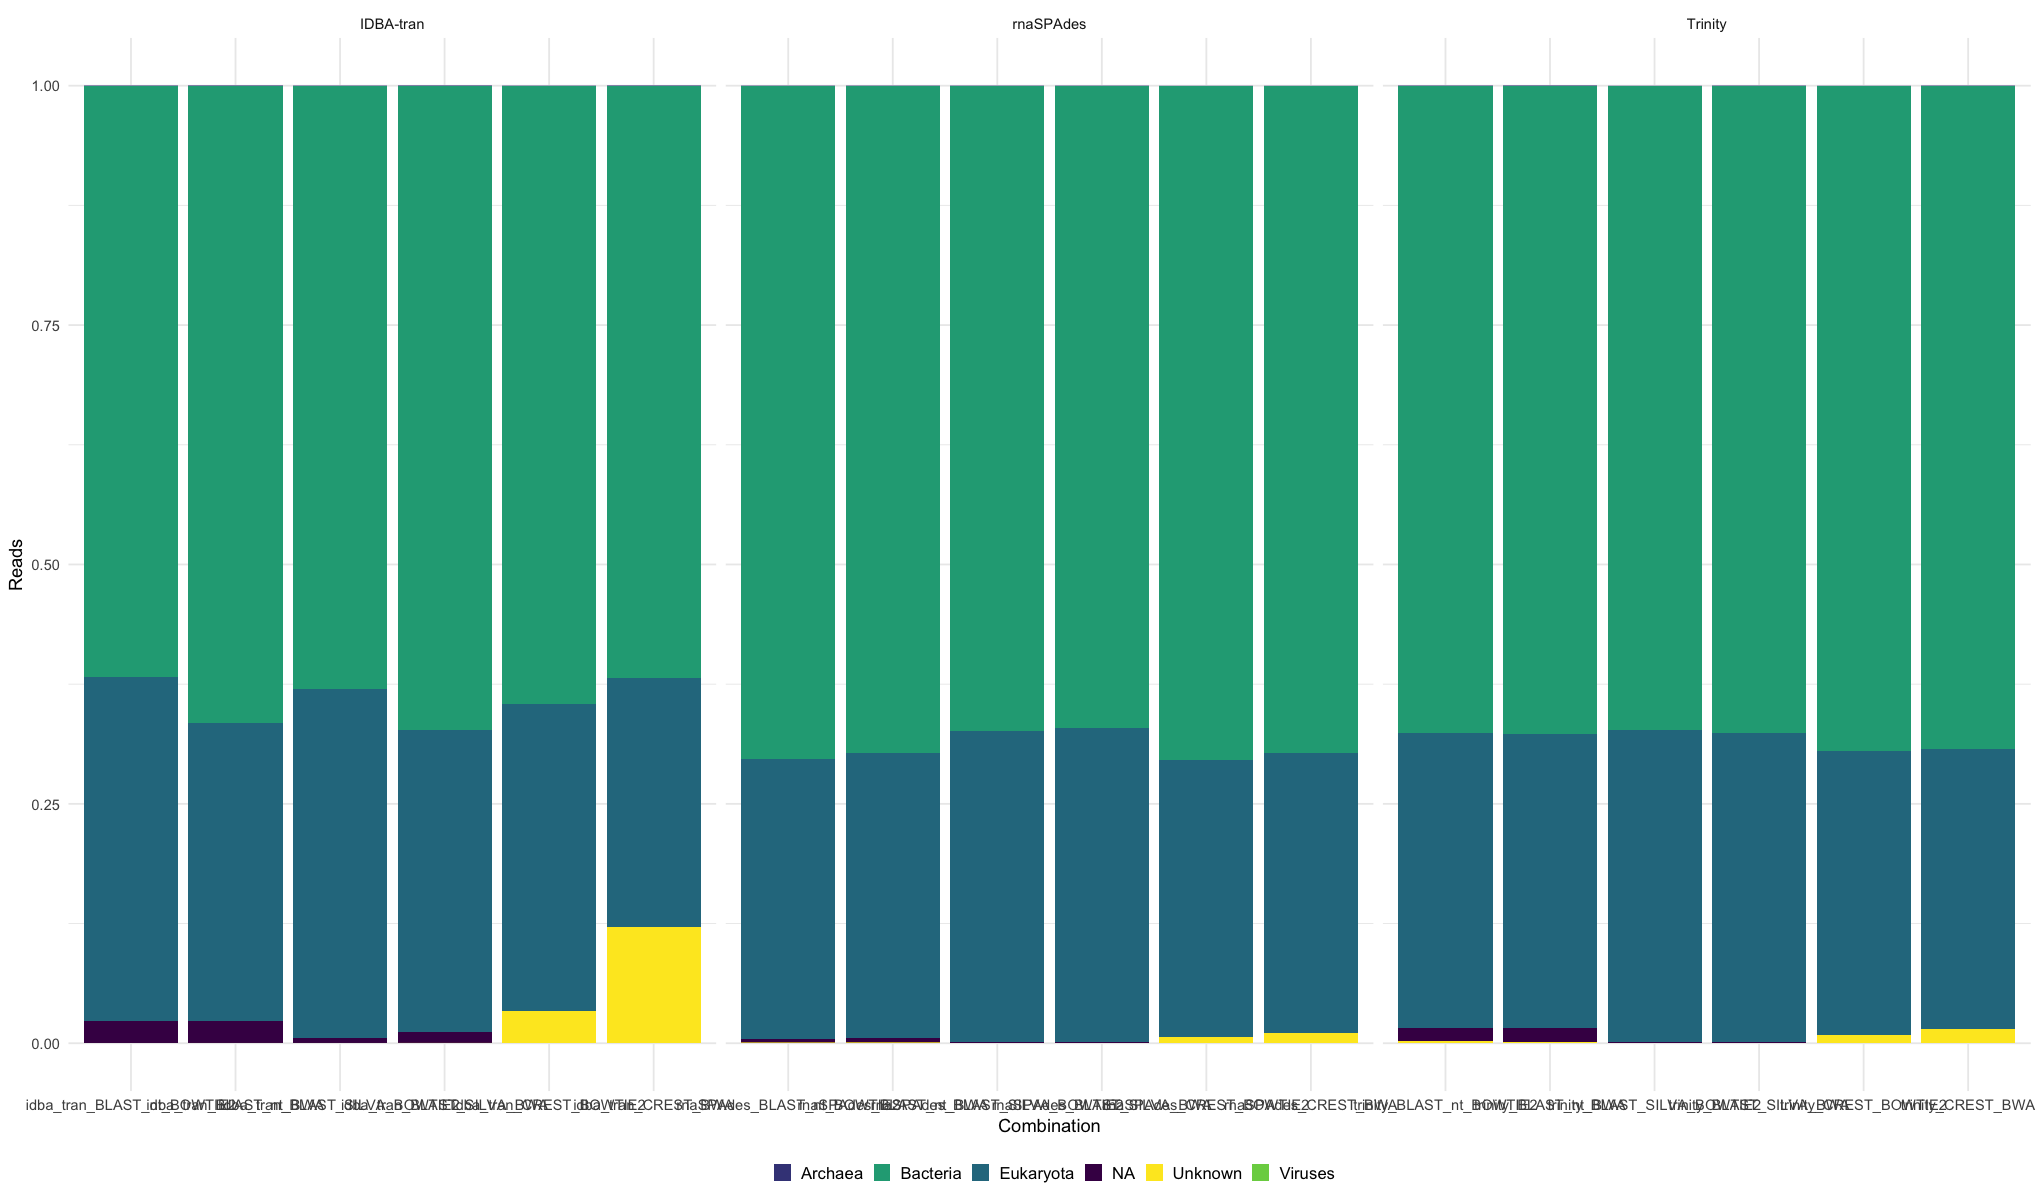

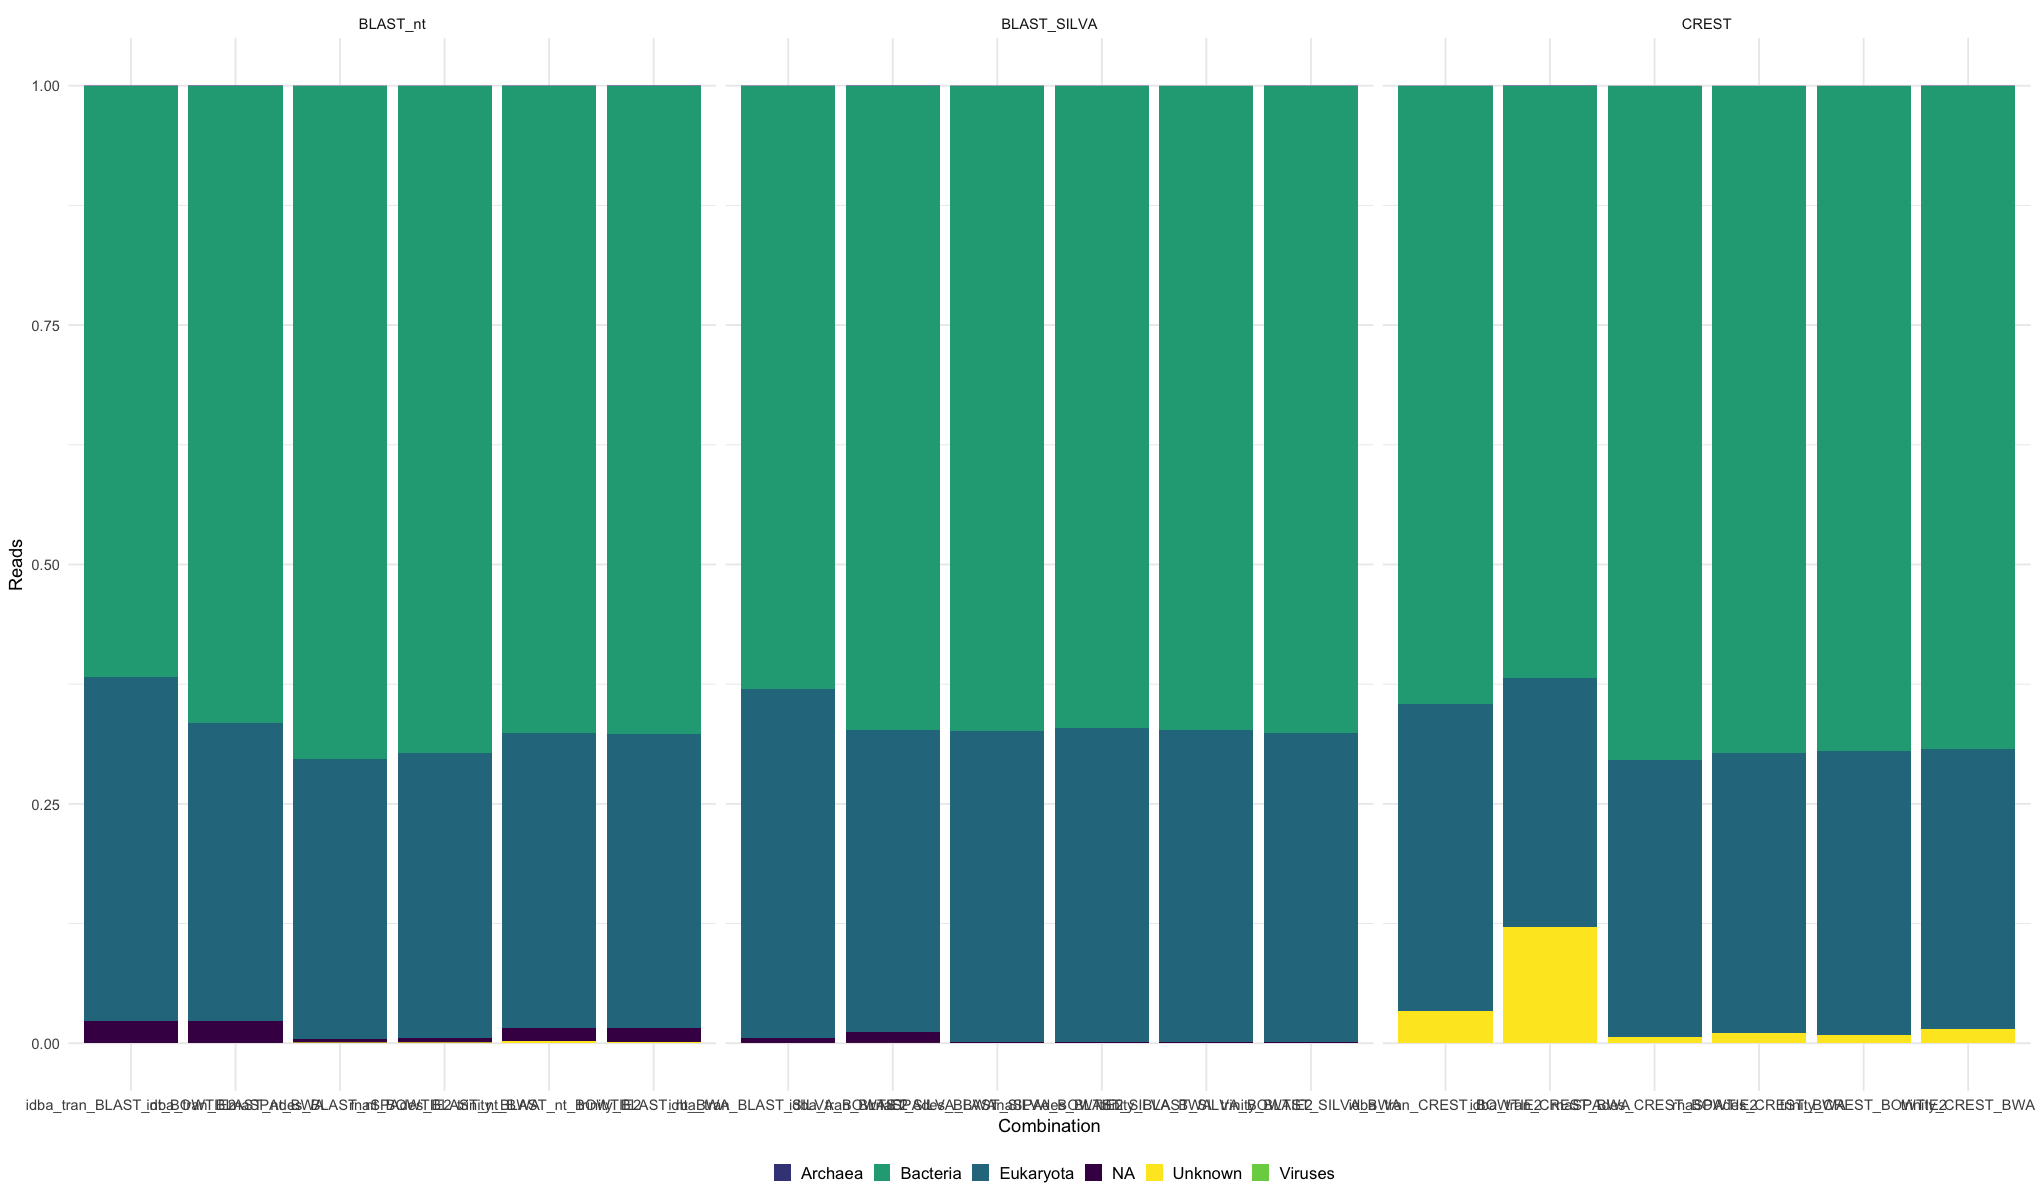

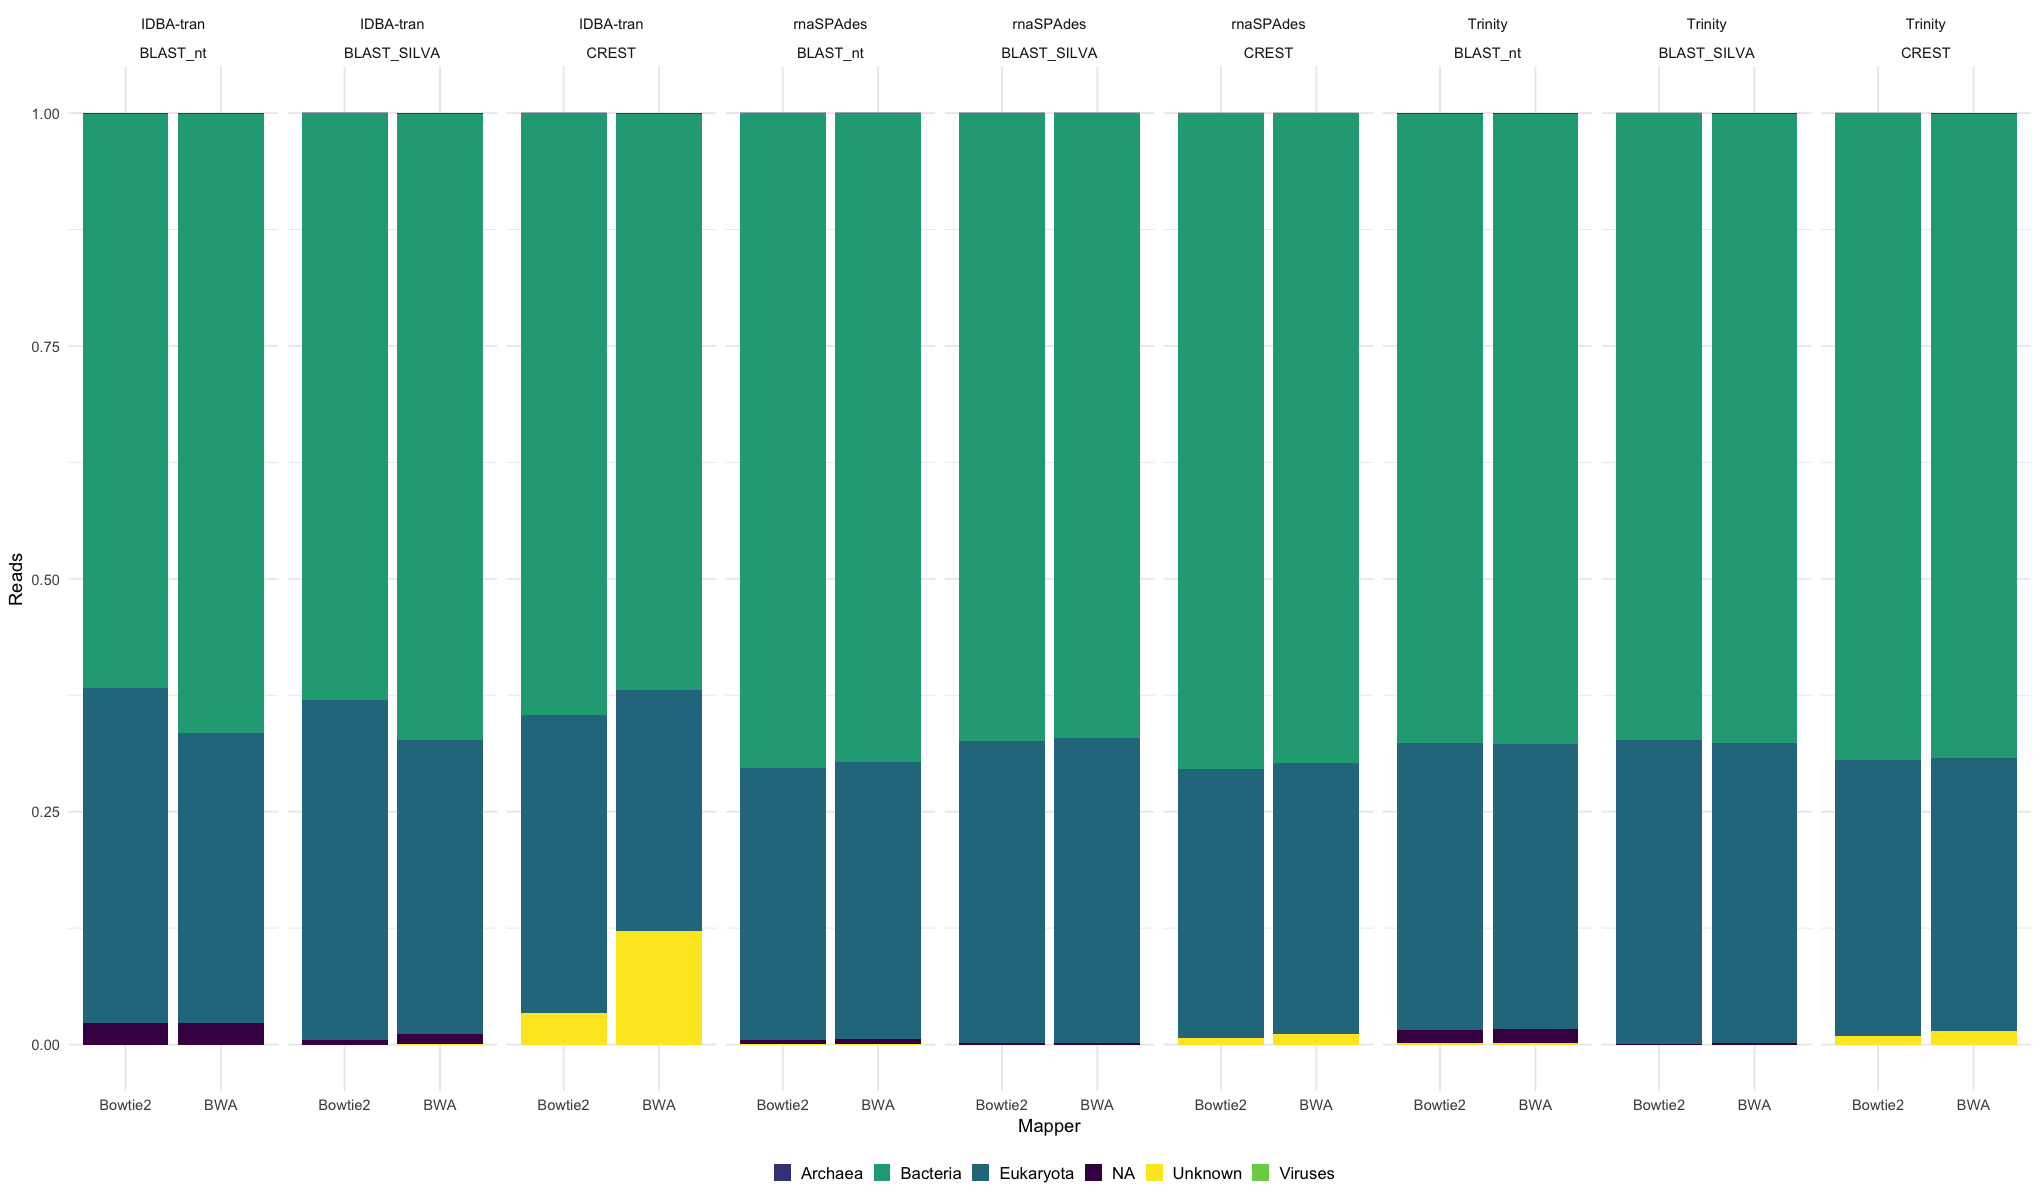

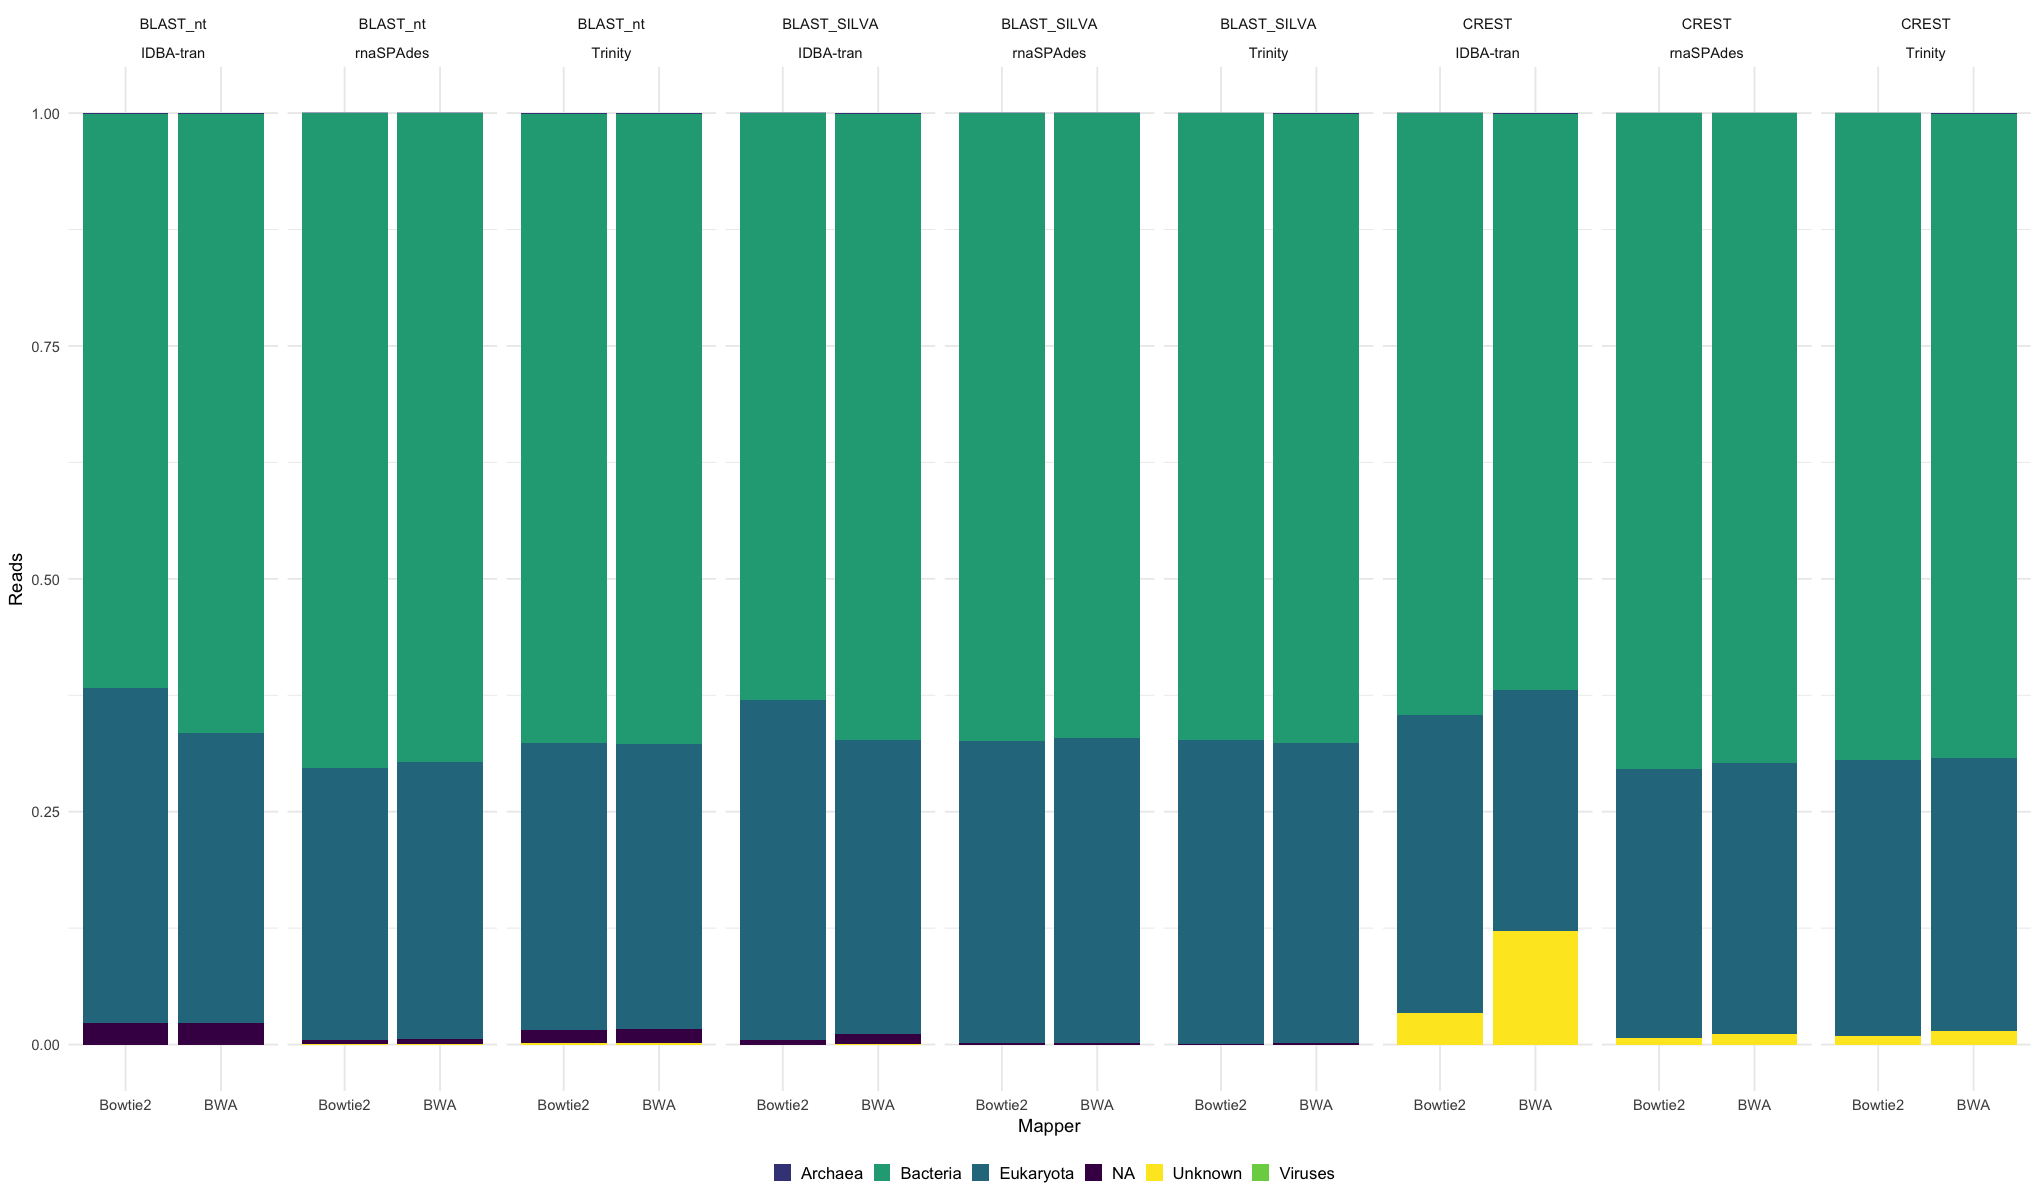

In [92]:
# Plot grouped by assembler
plot2<-ggplot(superkingdom_melted, aes(x = Combination, y = Reads, fill = Group))+
  #geom_bar(stat = 'identity', position = 'stack', colour="black")+
  geom_bar(stat = 'identity', position = 'stack')+
  # facet_grid(Assembler ~ Classifier, scales = "free", space = "free")+
  facet_grid( ~ Assembler, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_superkingdom)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot2
#ggsave("Plot2.png", plot=plot2,  device="png",  width=240, units="mm")

# Plot grouped by classifier
plot3<-ggplot(superkingdom_melted, aes(x = Combination, y = Reads, fill = Group))+
  #geom_bar(stat = 'identity', position = 'stack', colour="black")+
  geom_bar(stat = 'identity', position = 'stack')+
  # facet_grid(Assembler ~ Classifier, scales = "free", space = "free")+
  facet_grid( ~ Classifier, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_superkingdom)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot3
#ggsave("Plot3.png", plot=plot3,  device="png",  width=240, units="mm")

# Plot grouped by assembler and classifier
plot4<-ggplot(superkingdom_melted, aes(x = Mapper, y = Reads, fill = Group))+
  #geom_bar(stat = 'identity', position = 'stack', colour="black")+
  geom_bar(stat = 'identity', position = 'stack')+
# facet_grid(Assembler ~ Classifier, scales = "free", space = "free")+
  facet_grid( ~ Assembler + Classifier, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_superkingdom)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot4
#ggsave("Plot4.png", plot=plot4,  device="png",  width=240, units="mm")

# Plot grouped by classifier and assembler
plot5<-ggplot(superkingdom_melted, aes(x = Mapper, y = Reads, fill = Group))+
  #geom_bar(stat = 'identity', position = 'stack', colour="black")+
  geom_bar(stat = 'identity', position = 'stack')+
# facet_grid(Assembler ~ Classifier, scales = "free", space = "free")+
  facet_grid( ~ Classifier + Assembler , scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_superkingdom)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot5
#ggsave("Plot5.png", plot=plot5,  device="png",  width=240, units="mm")


## 4.3 Plot data assigned to phylum

If you want to save the plots using the script, uncomment the ggsave commands after each plot

### 4.3.1 With viridis colours in random order <u>(colourblind-friendly)</u>

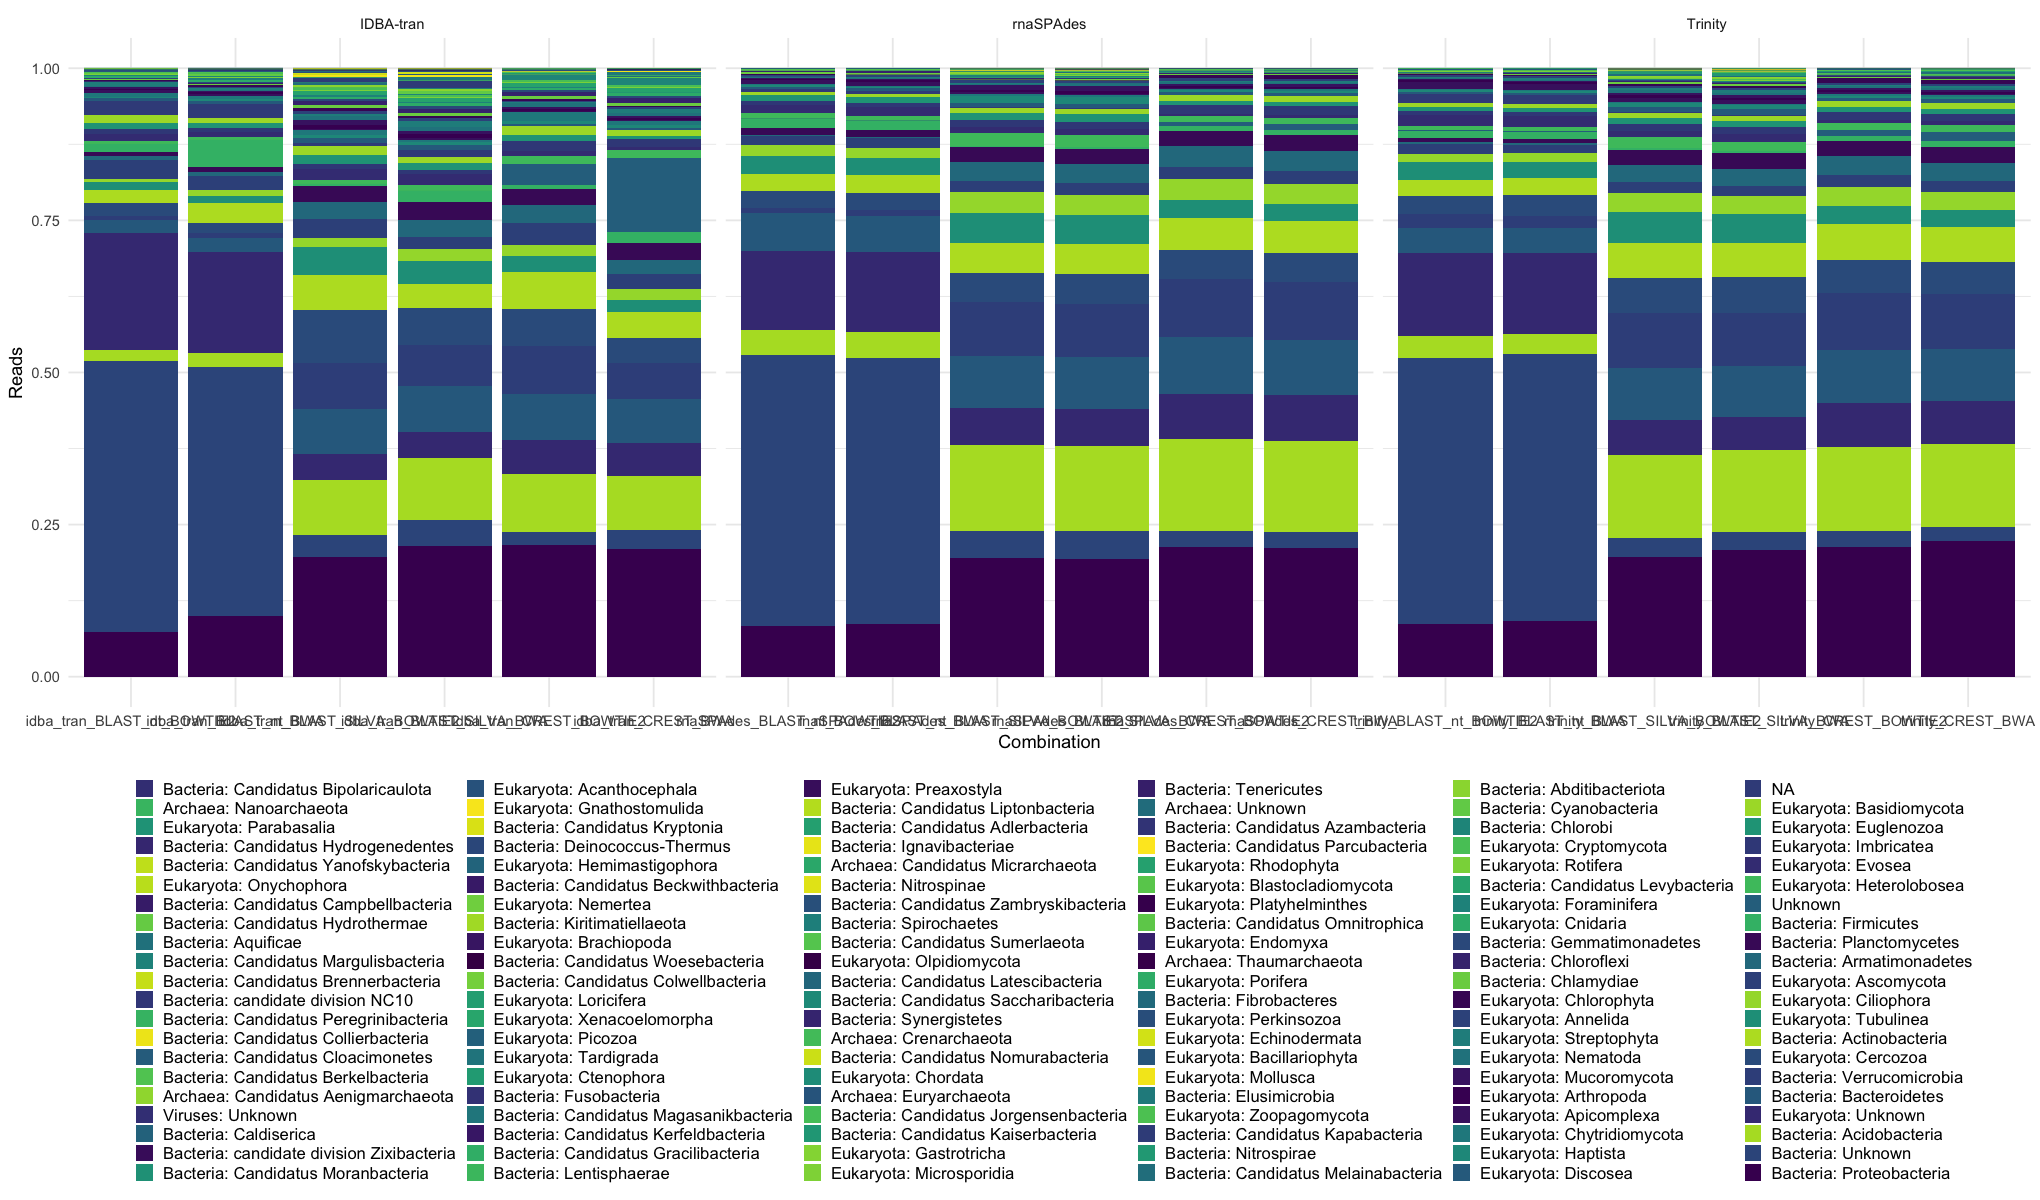

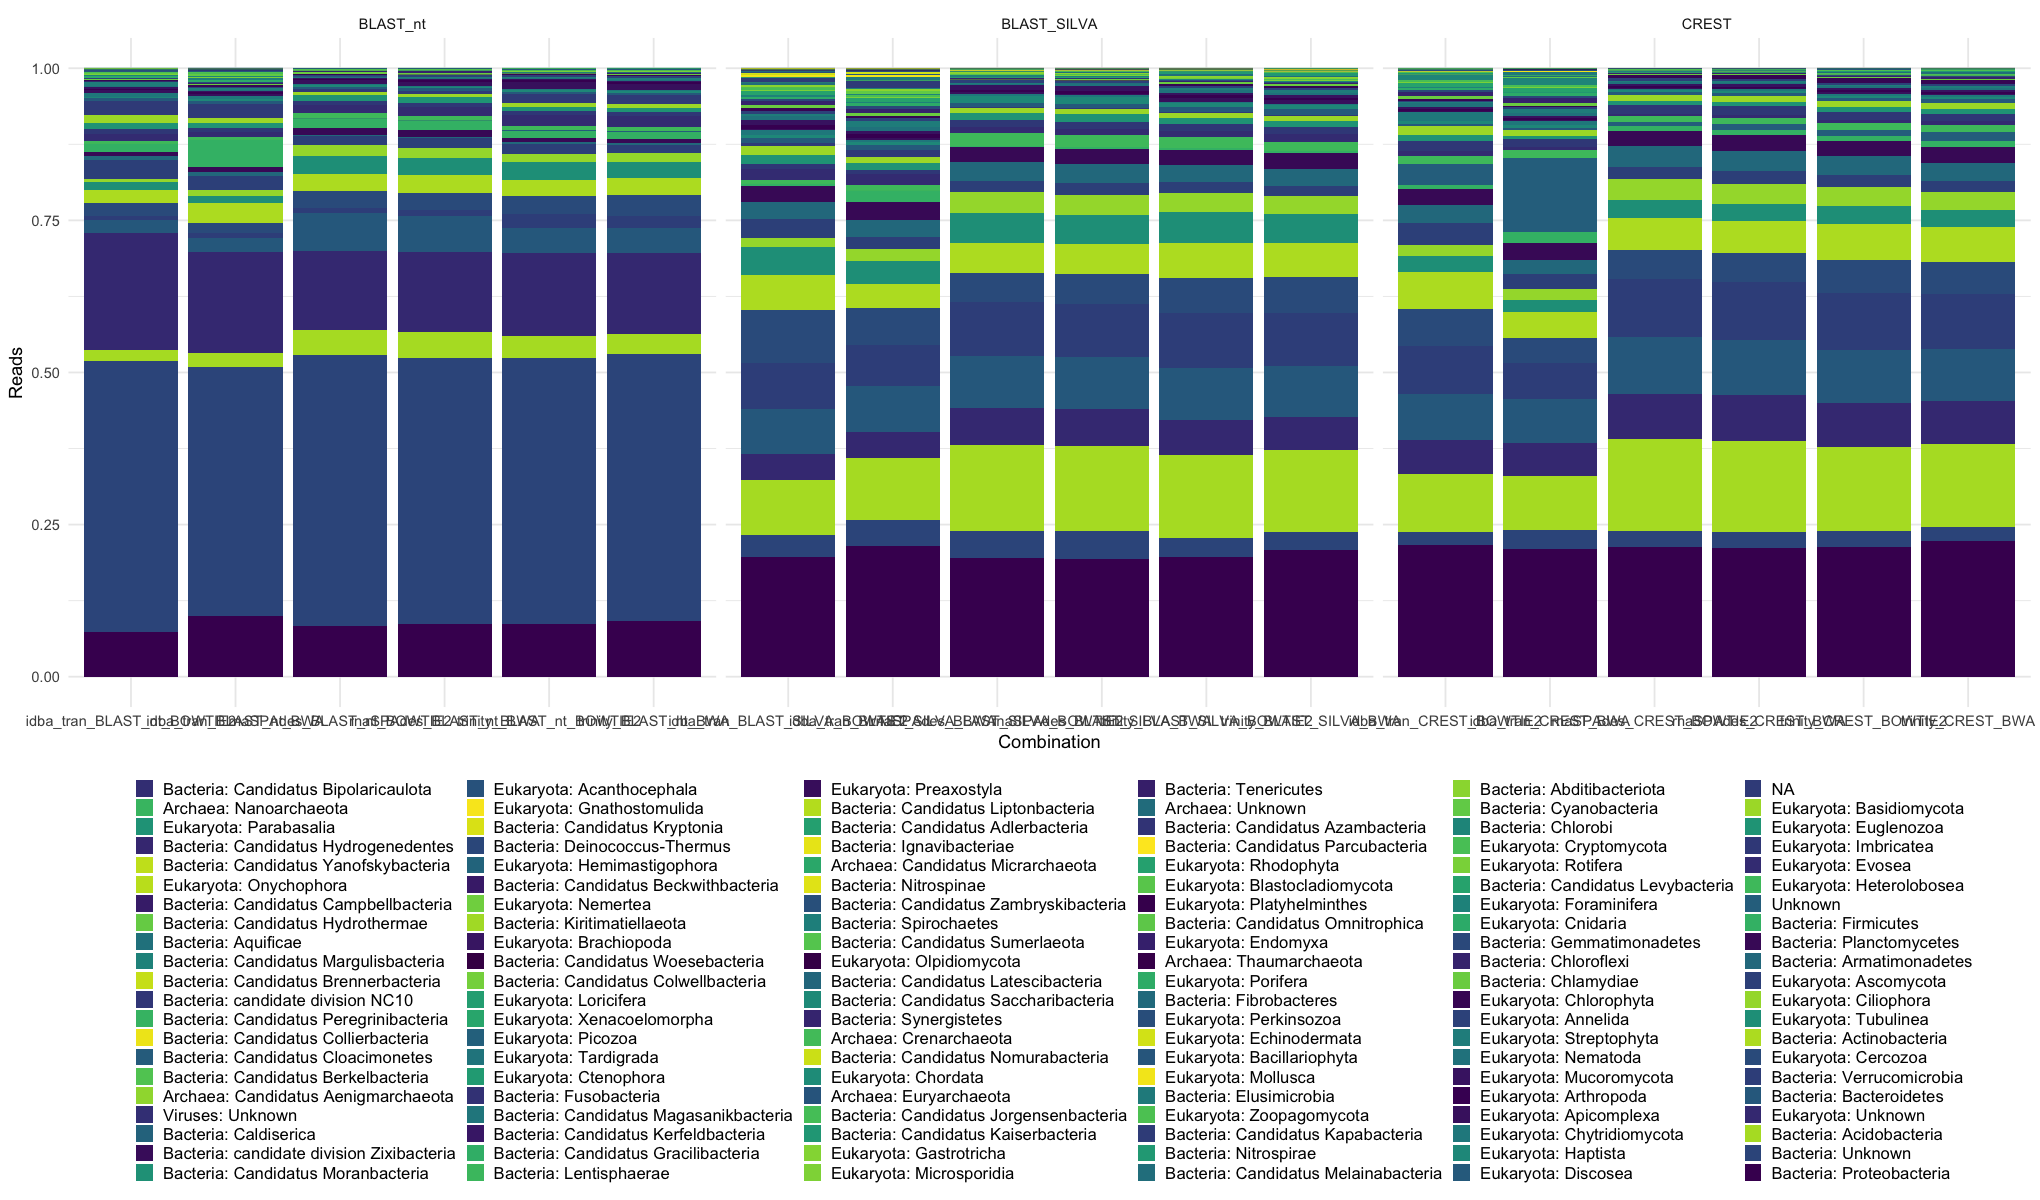

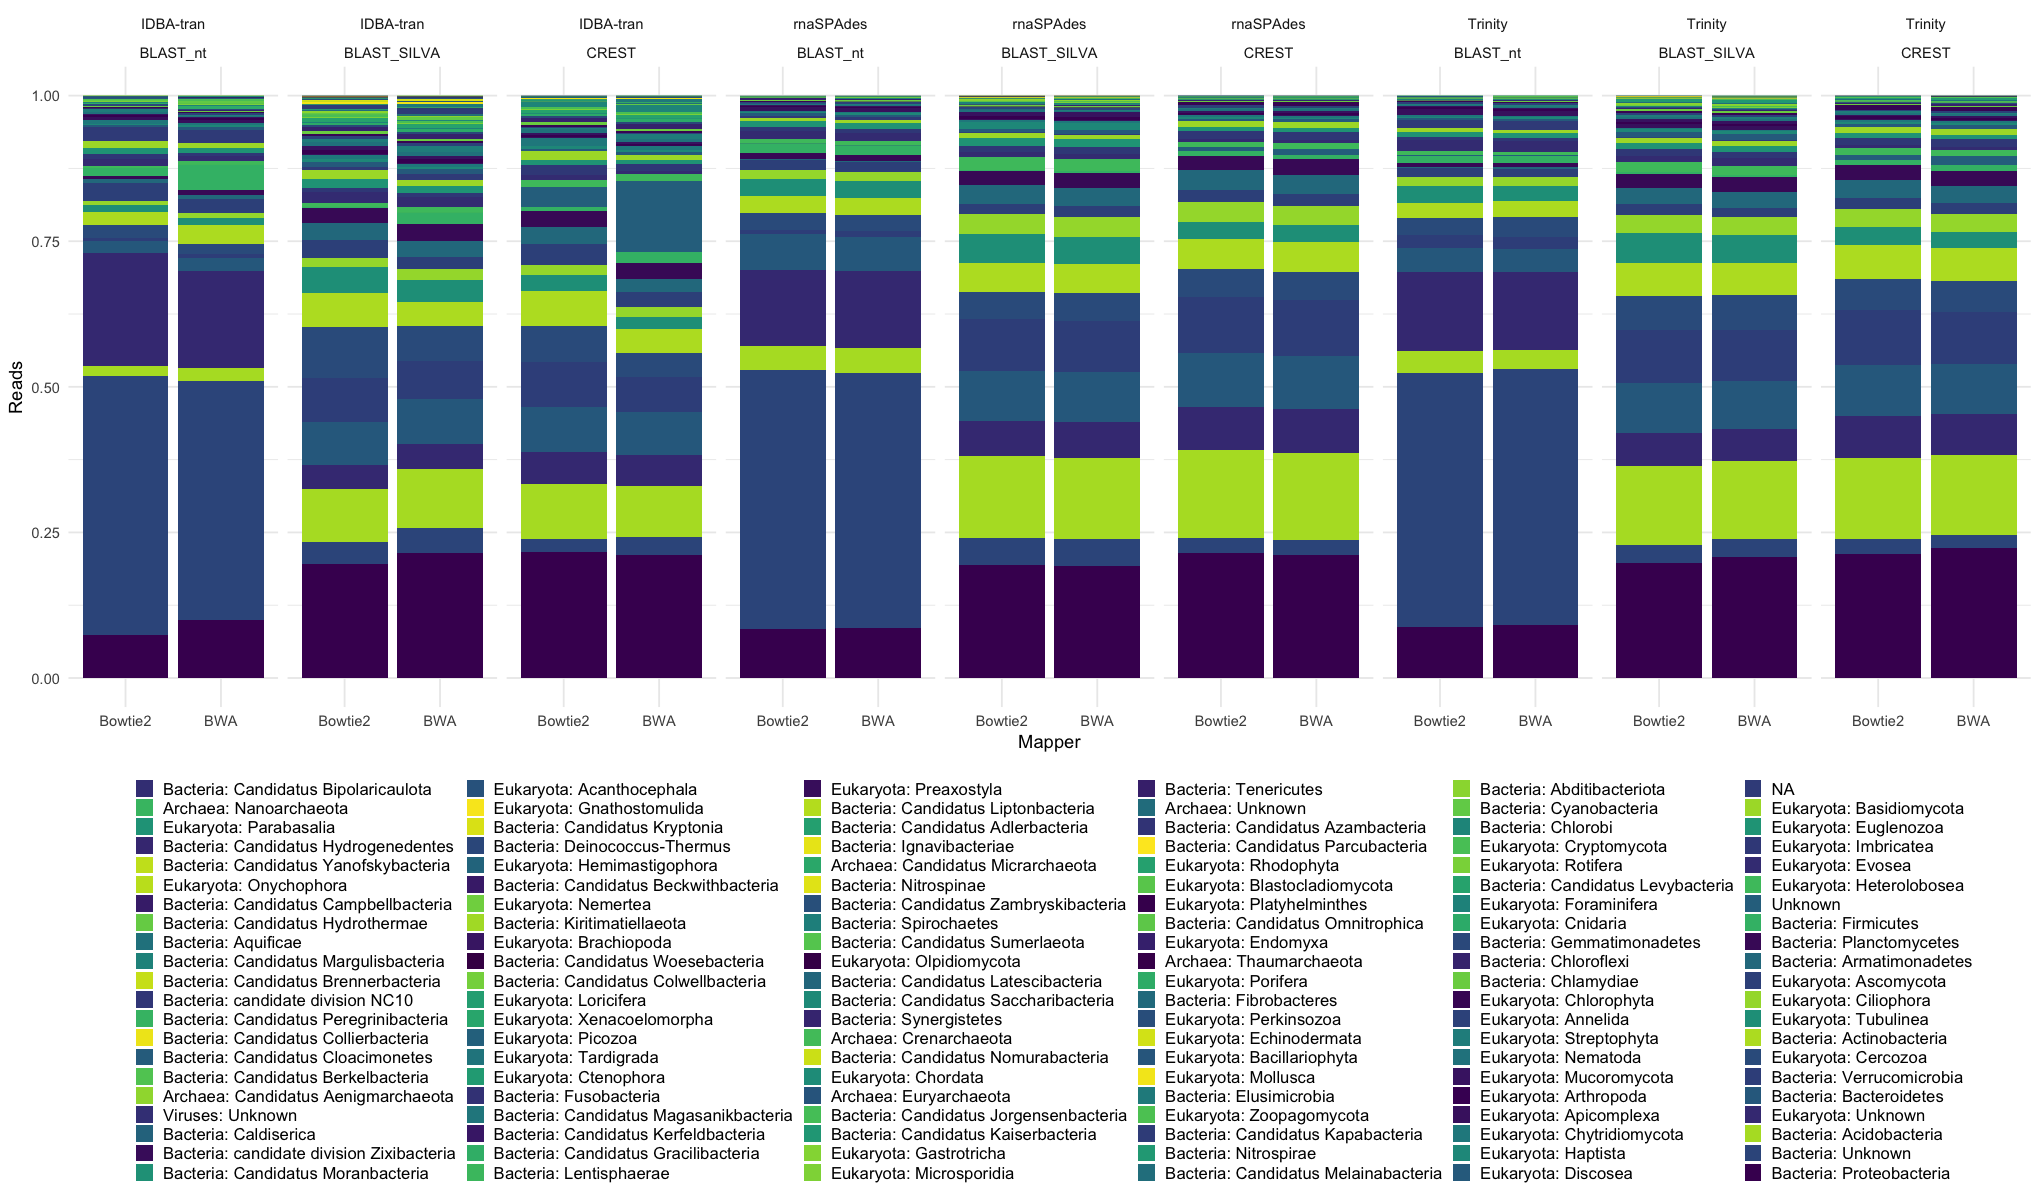

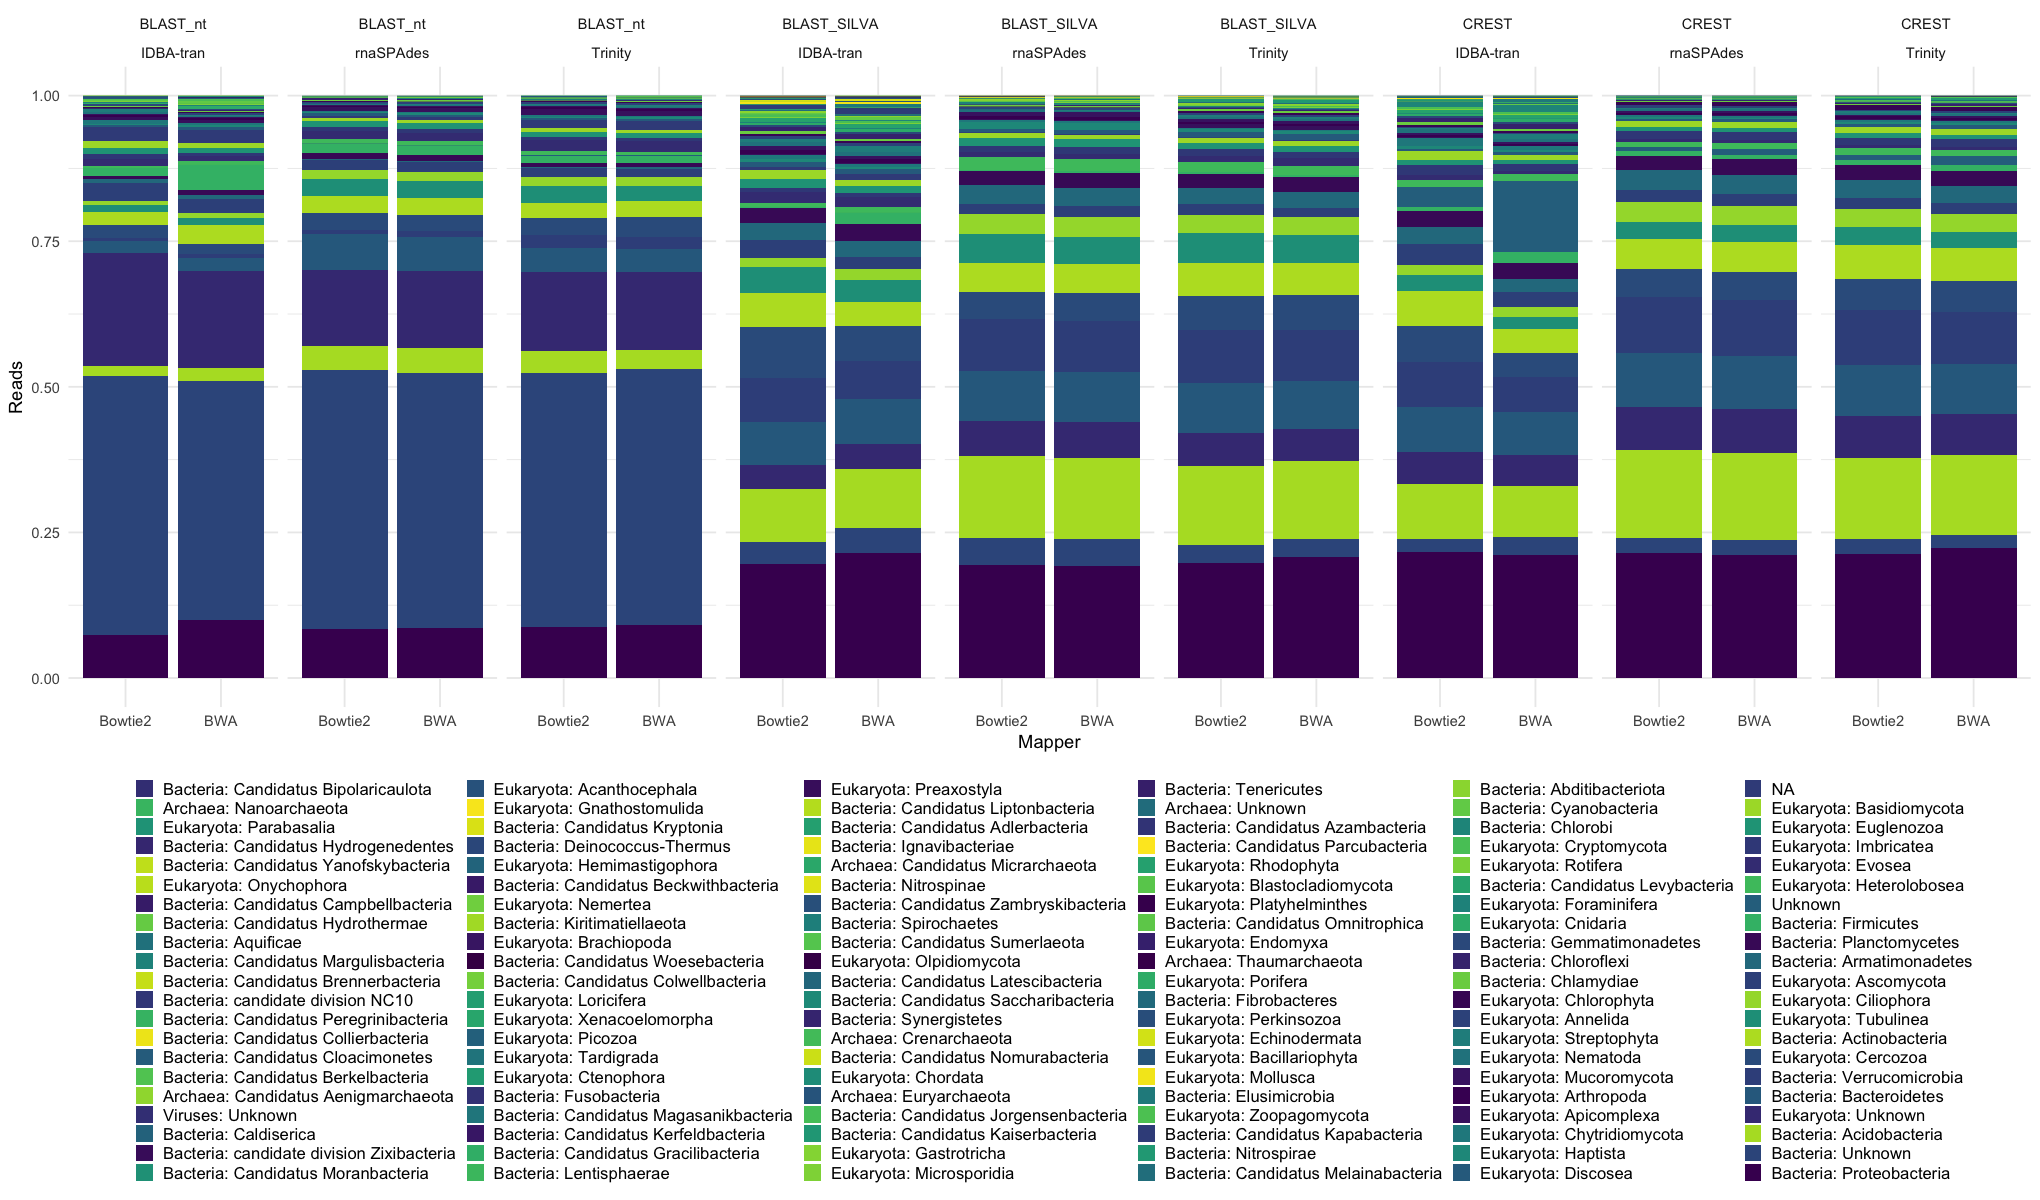

In [133]:
# Plot grouped by assembler
plot6<-ggplot(phylum_melted, aes(x = Combination, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Assembler, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_phylum)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot6
#ggsave("Plot6.png", plot=plot6,  device="png",  width=240, units="mm")

# Plot grouped by classifier
plot7<-ggplot(phylum_melted, aes(x = Combination, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Classifier, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_phylum)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot7
#ggsave("Plot7.png", plot=plot7,  device="png",  width=240, units="mm")

# Plot grouped by assembler and classifier
plot8<-ggplot(phylum_melted, aes(x = Mapper, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Assembler + Classifier, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_phylum)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot8
#ggsave("Plot8.png", plot=plot8,  device="png",  width=240, units="mm")

# Plot grouped by classifier and assembler
plot9<-ggplot(phylum_melted, aes(x = Mapper, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Classifier + Assembler, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_phylum)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot9
#ggsave("Plot9.png", plot=plot9,  device="png",  width=240, units="mm")

### 4.3.2 With different <u>colourblind-friendly</u> colour palettes per corresponding superkingdom

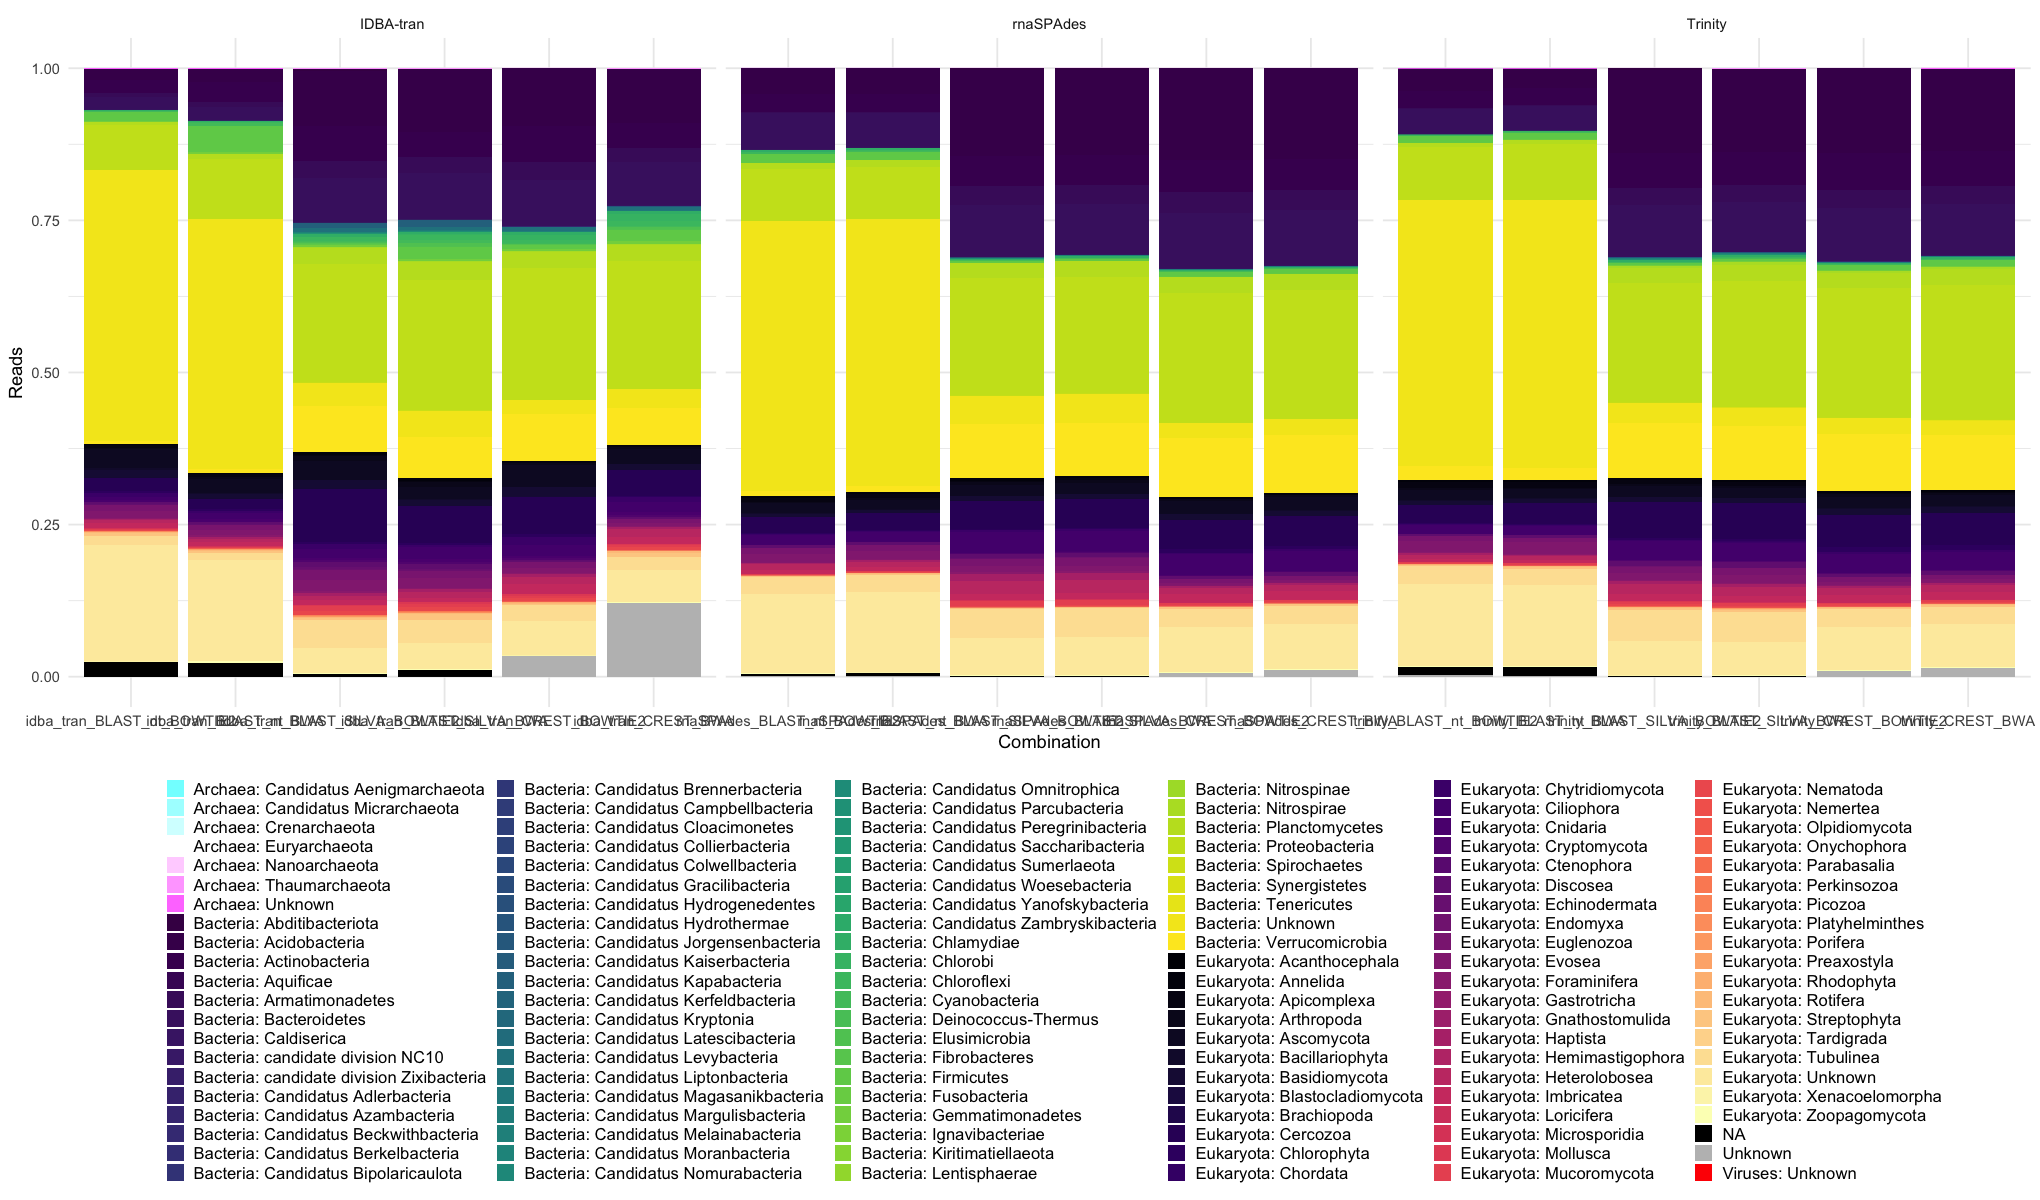

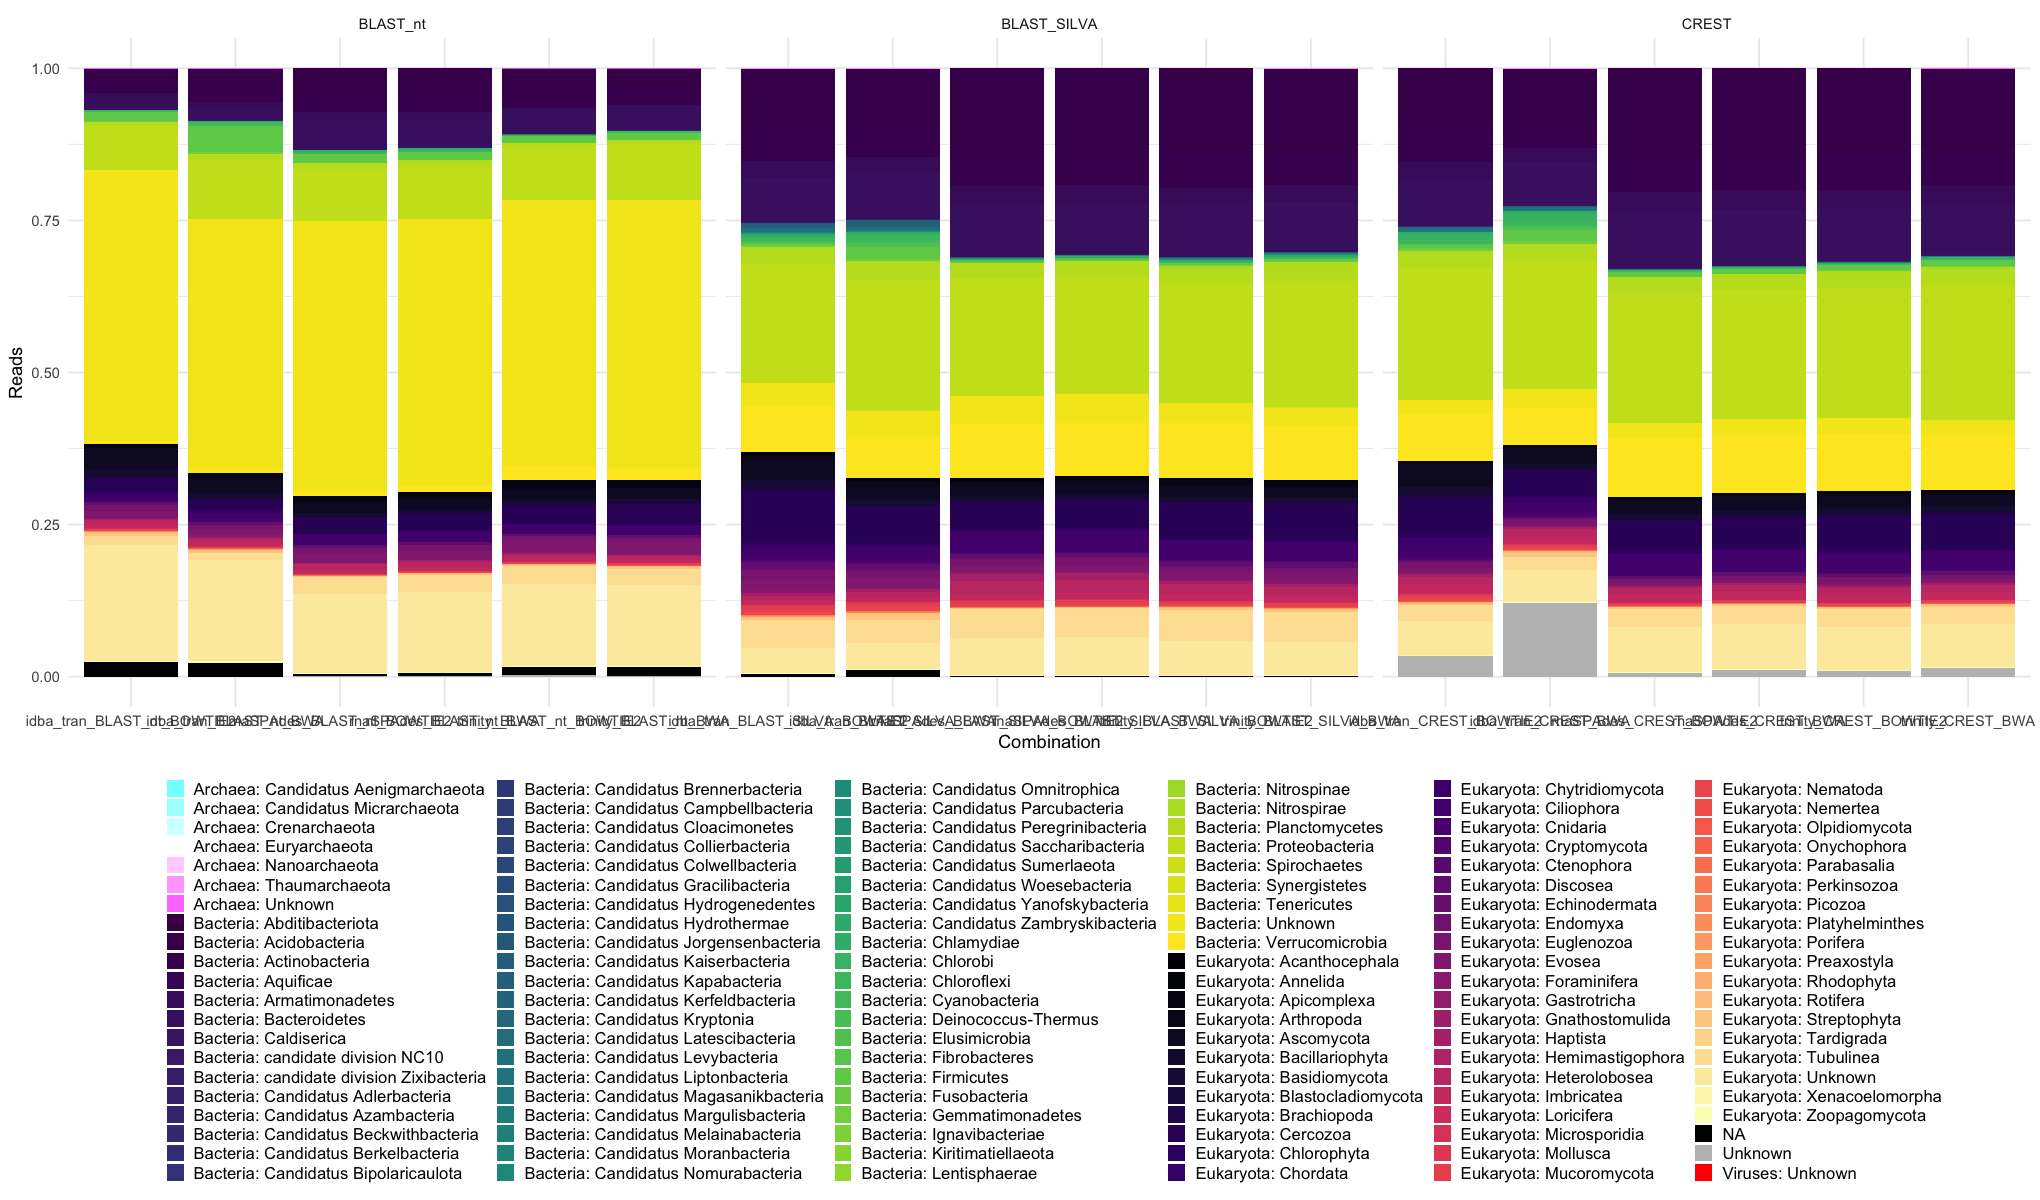

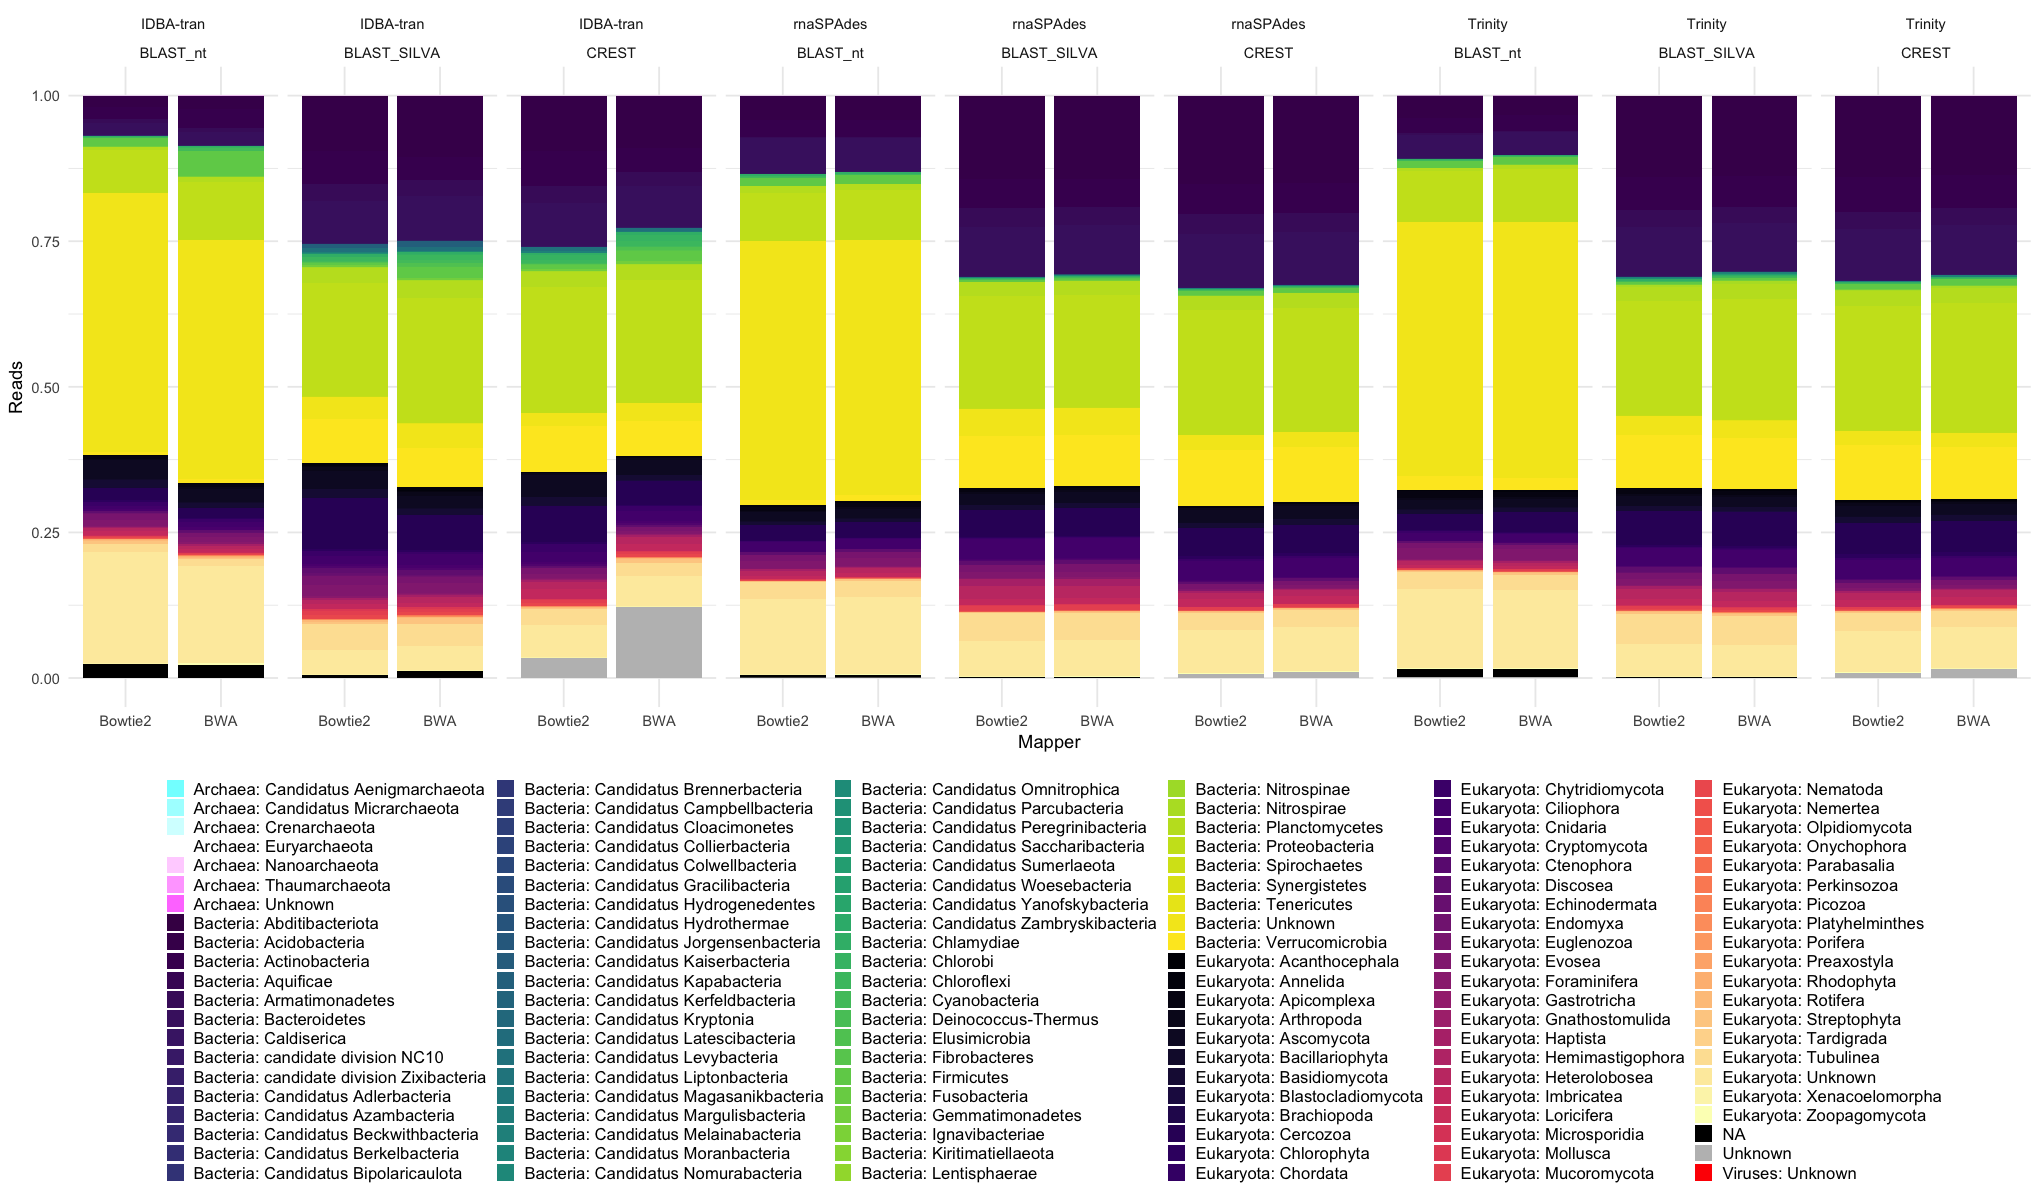

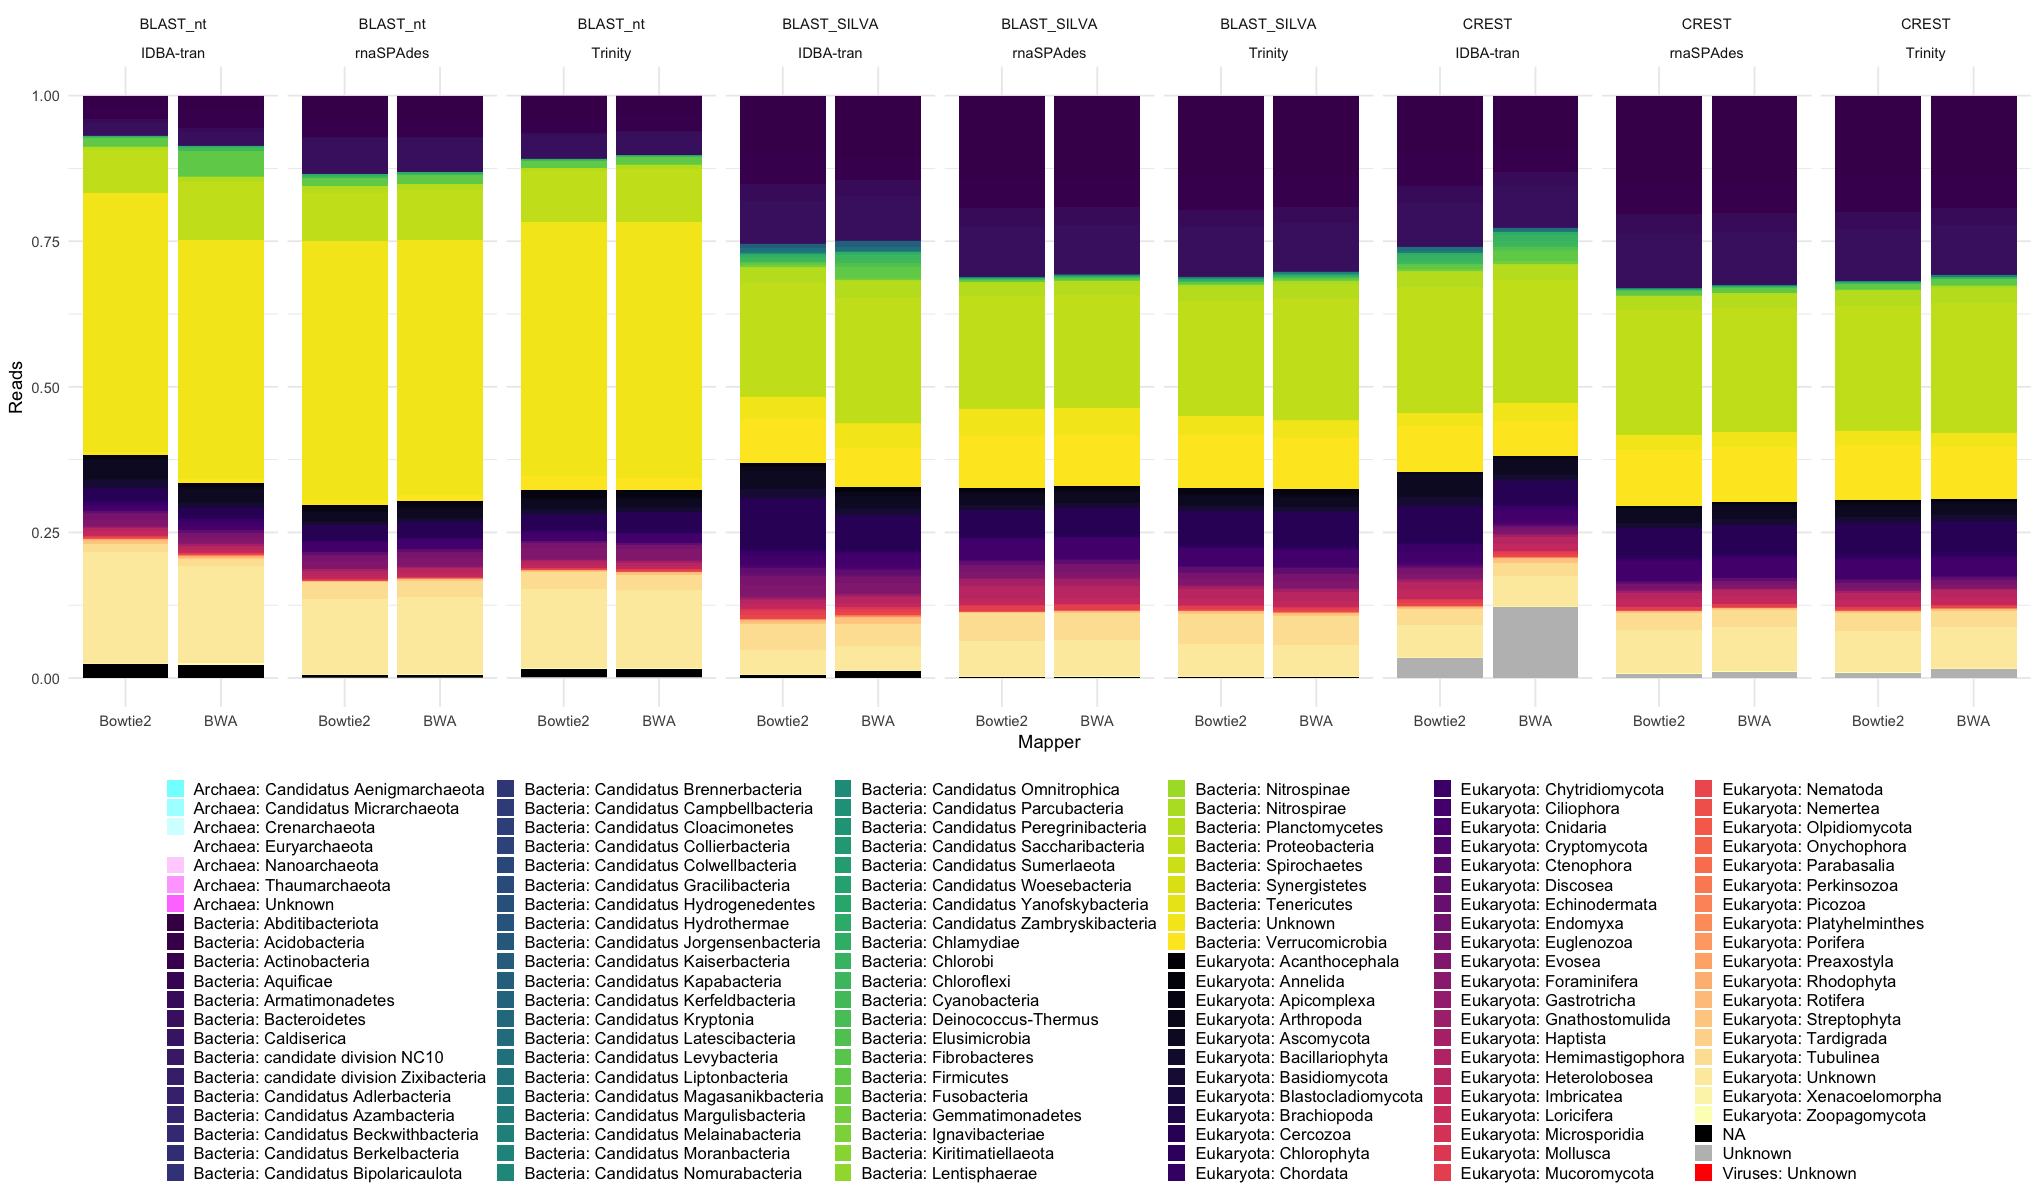

In [19]:
# Plot grouped by assembler
plot10<-ggplot(phylum_melted, aes(x = Combination, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Assembler, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec1_phylum_superkingdoms)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot10
#ggsave("Plot10.png", plot=plot10,  device="png",  width=240, units="mm")

# Plot grouped by classifier
plot11<-ggplot(phylum_melted, aes(x = Combination, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Classifier, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec1_phylum_superkingdoms)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot11
#ggsave("Plot11.png", plot=plot11,  device="png",  width=240, units="mm")

# Plot grouped by assembler and classifier
plot12<-ggplot(phylum_melted, aes(x = Mapper, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Assembler + Classifier, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec1_phylum_superkingdoms)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot12
#ggsave("Plot12.png", plot=plot12,  device="png",  width=240, units="mm")

# Plot grouped by classifier and assembler
plot13<-ggplot(phylum_melted, aes(x = Mapper, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Classifier + Assembler, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec1_phylum_superkingdoms)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot13
#ggsave("Plot13.png", plot=plot13,  device="png",  width=240, units="mm")

### 4.3.3 With different <u> non-colourblind-friendly </u> colour palettes per corresponding superkingdom

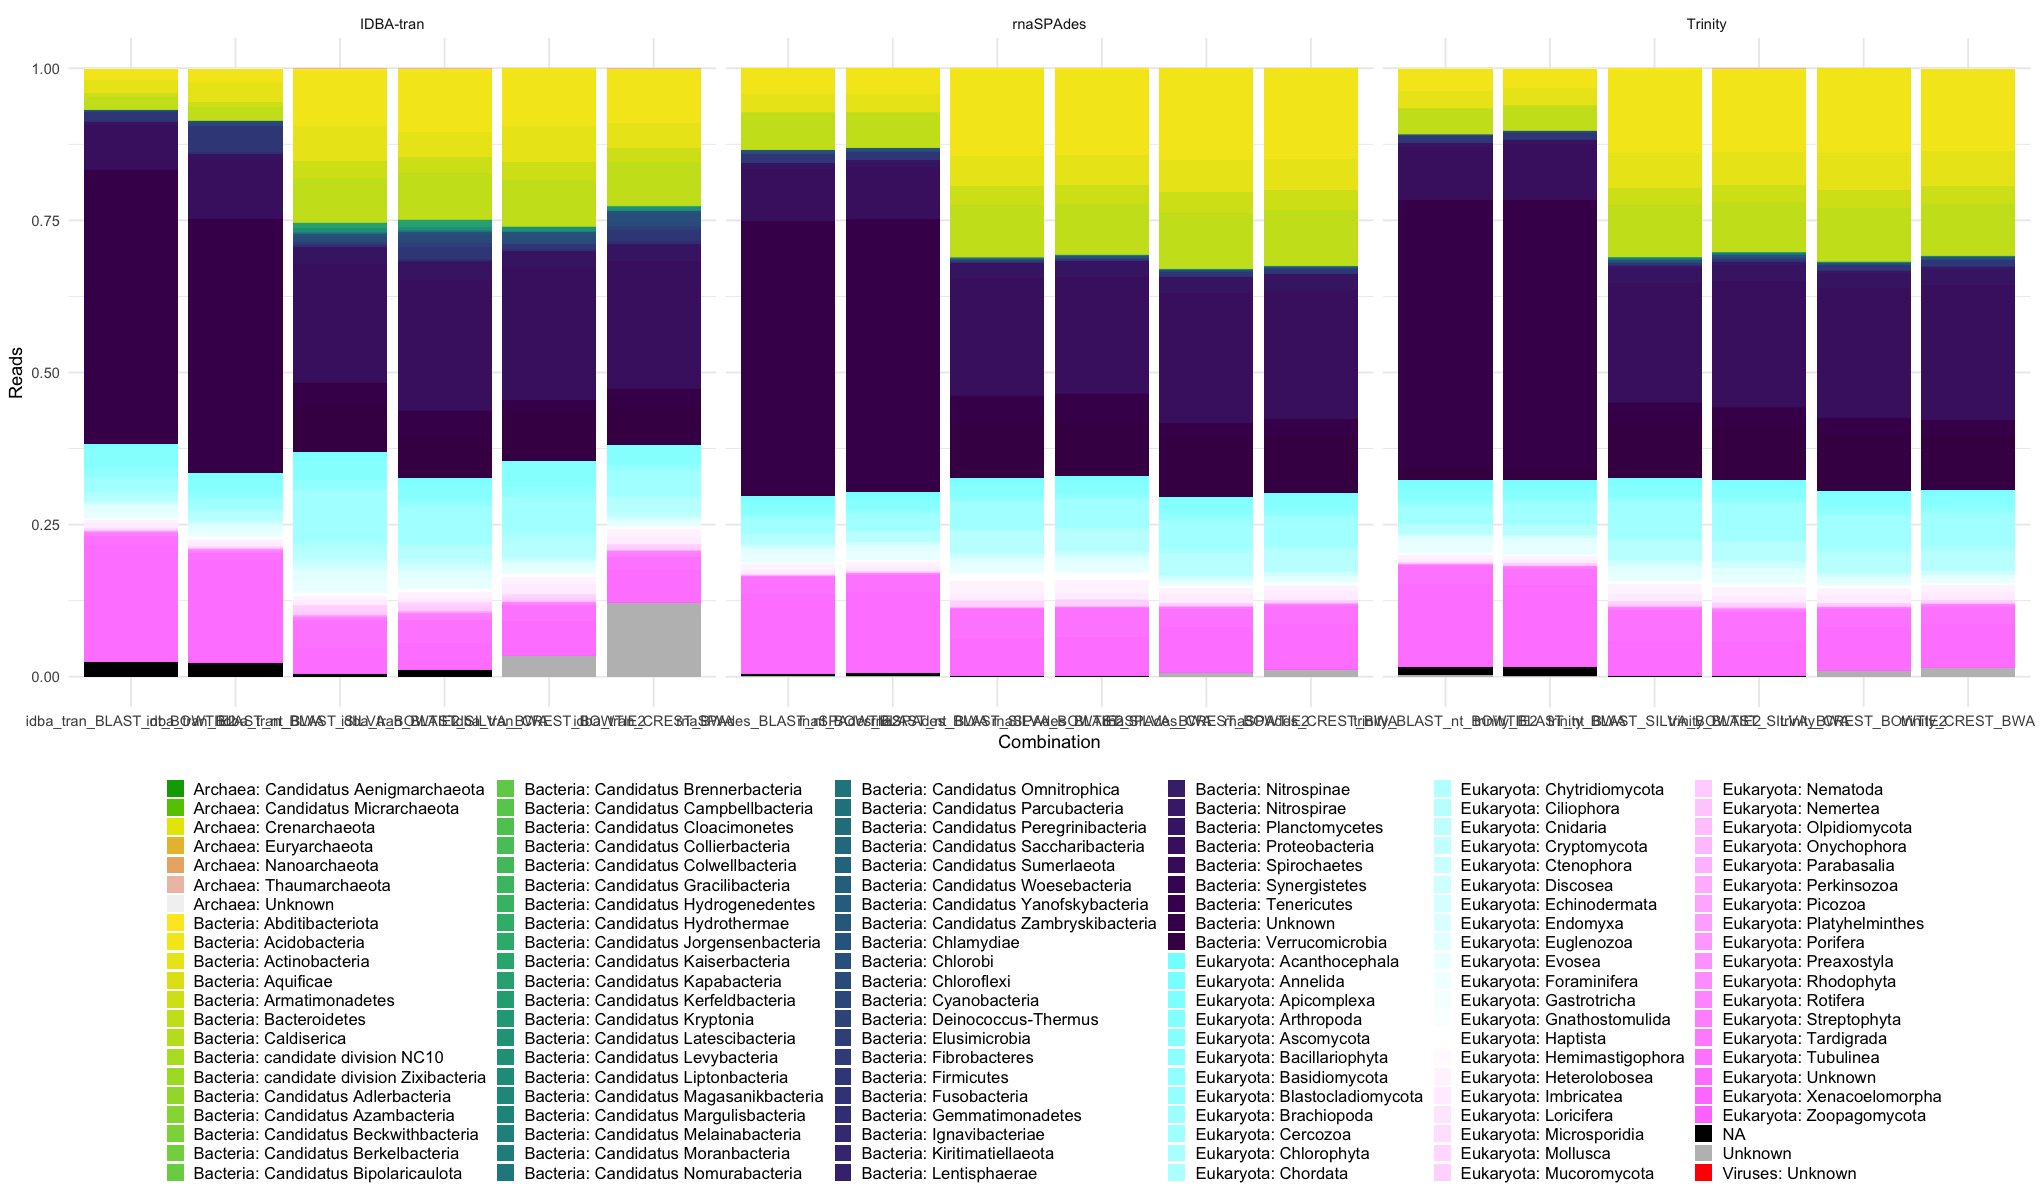

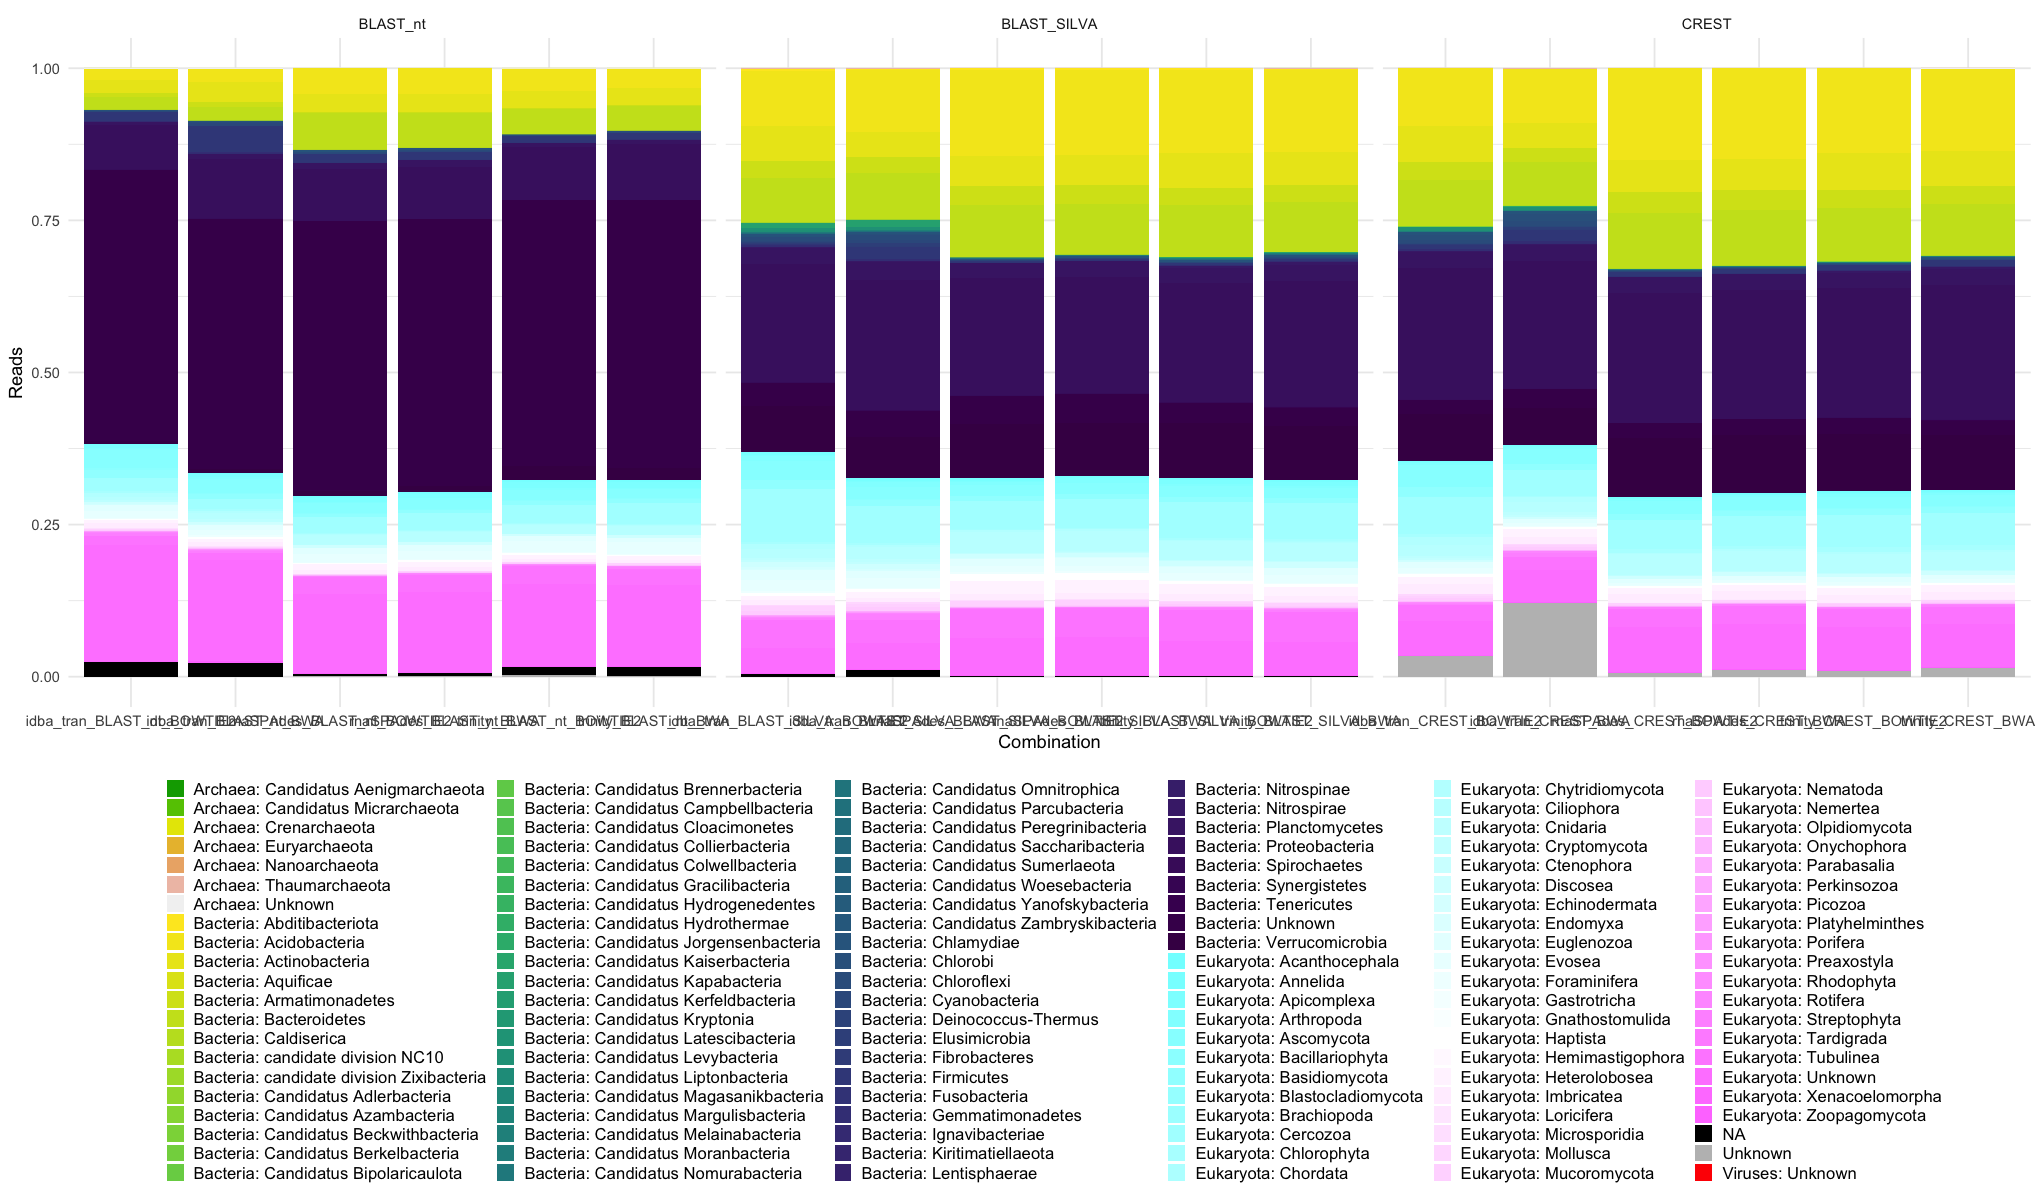

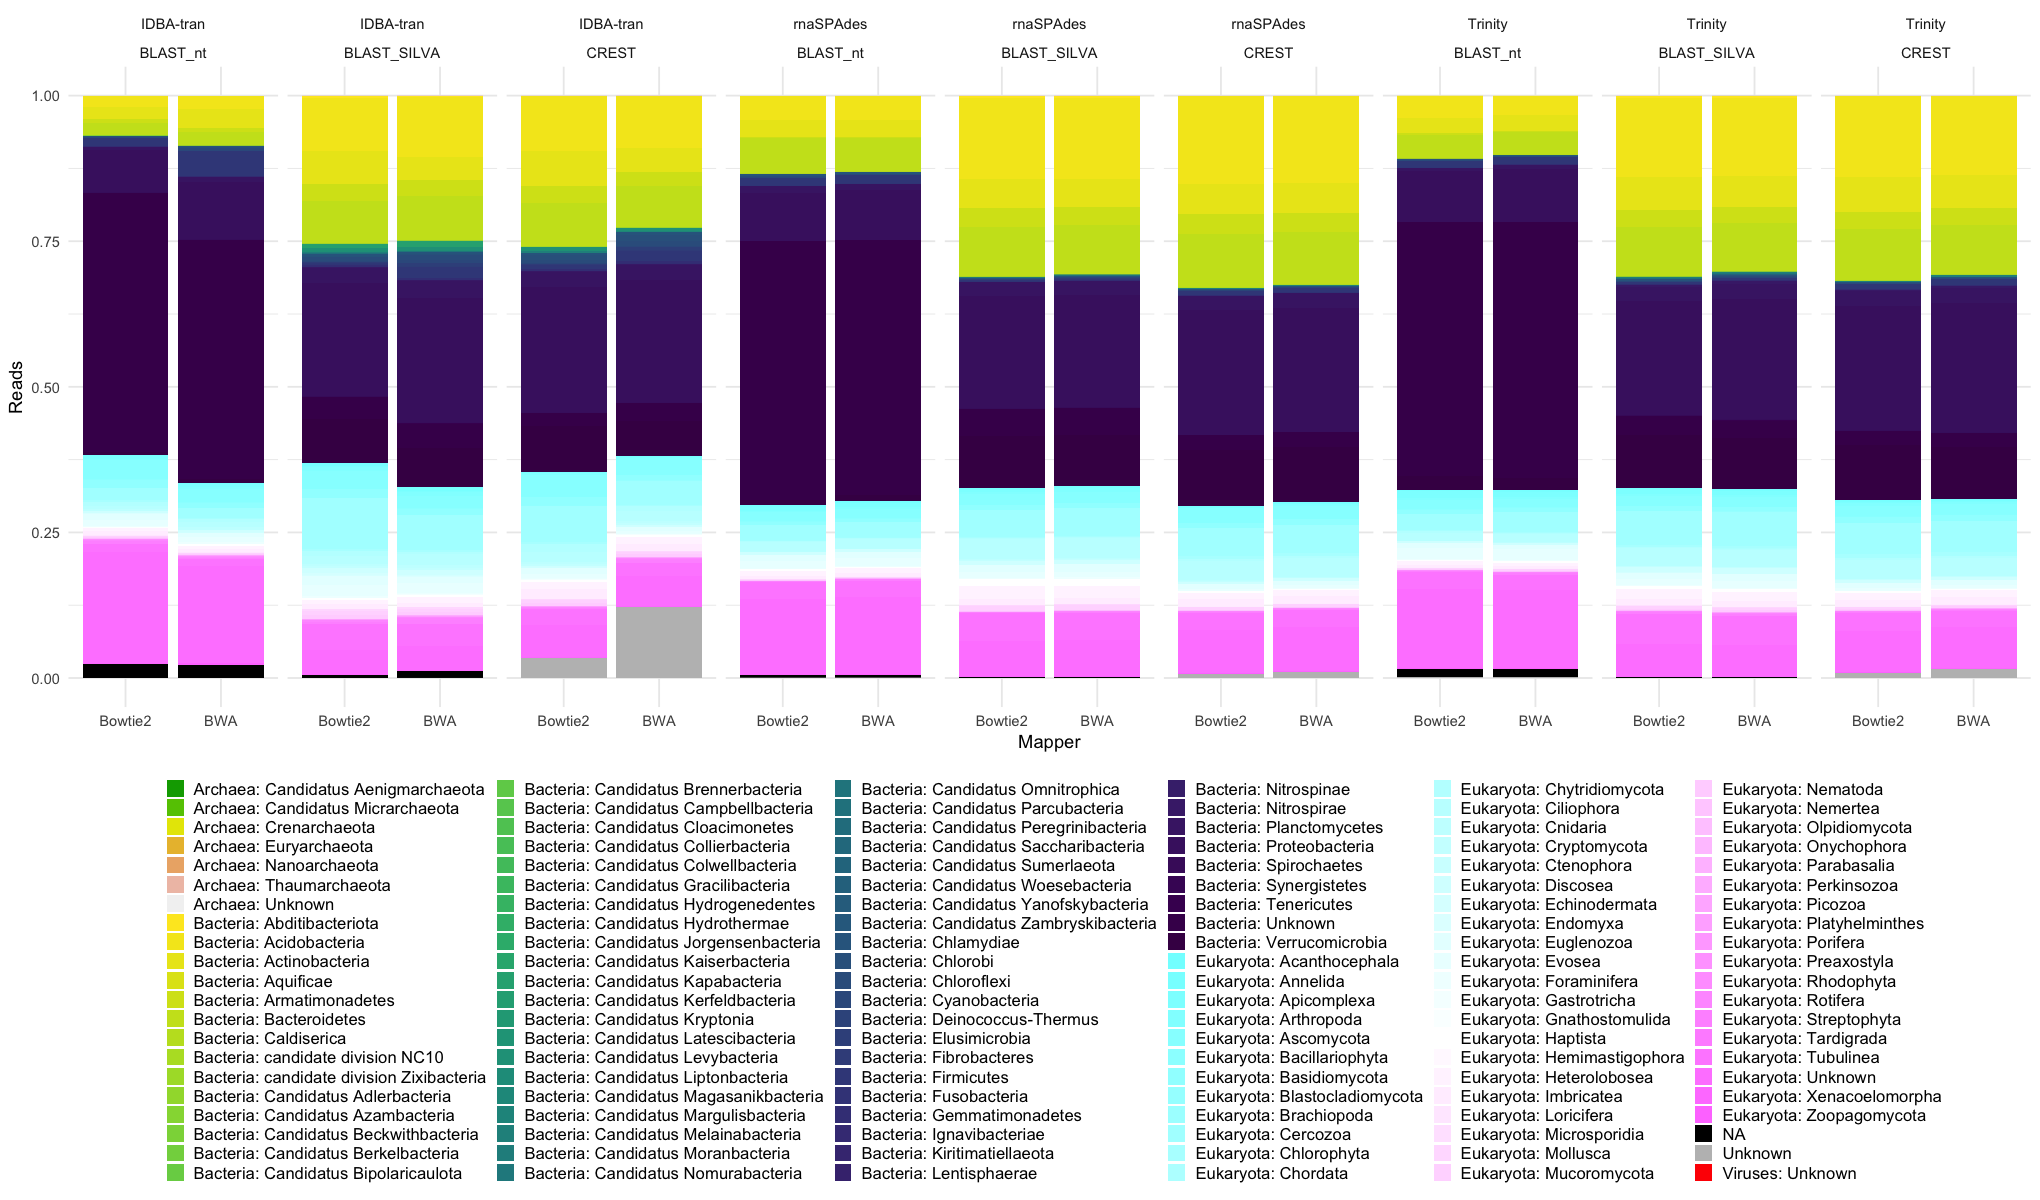

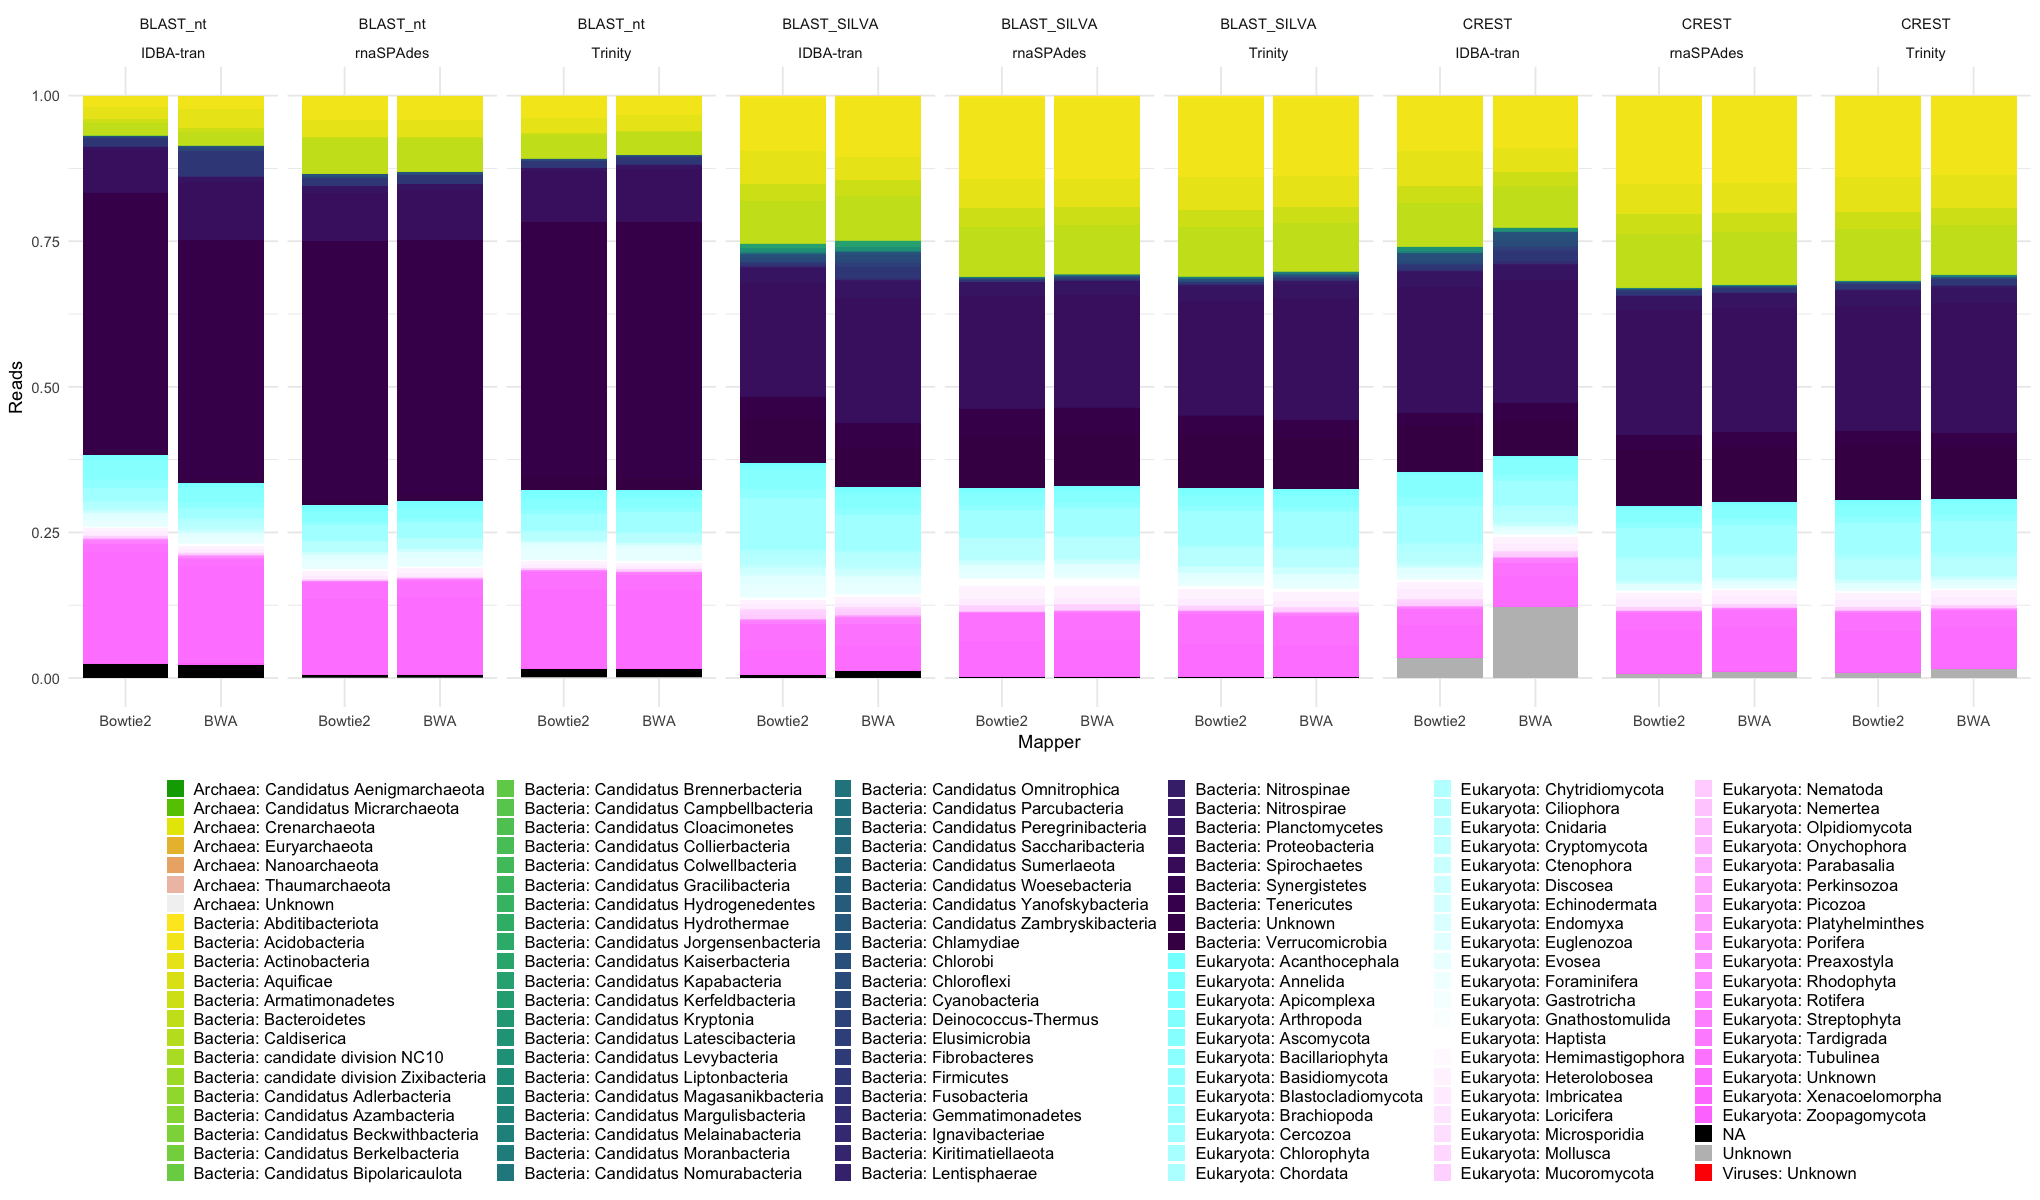

In [20]:
# Plot grouped by assembler
plot14<-ggplot(phylum_melted, aes(x = Combination, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Assembler, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec2_phylum_superkingdoms)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot14
#ggsave("Plot14.png", plot=plot14,  device="png",  width=240, units="mm")

# Plot grouped by classifier
plot15<-ggplot(phylum_melted, aes(x = Combination, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Classifier, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec2_phylum_superkingdoms)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot15
#ggsave("Plot15.png", plot=plot15,  device="png",  width=240, units="mm")

# Plot grouped by assembler and classifier
plot16<-ggplot(phylum_melted, aes(x = Mapper, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Assembler + Classifier, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec2_phylum_superkingdoms)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot16
#ggsave("Plot16.png", plot=plot16,  device="png",  width=240, units="mm")

# Plot grouped by classifier and assembler
plot17<-ggplot(phylum_melted, aes(x = Mapper, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Classifier + Assembler, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec2_phylum_superkingdoms)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot17
#ggsave("Plot17.png", plot=plot17,  device="png",  width=240, units="mm")

### 4.3.3 With different self-made, <u> non-colourblind-friendly </u> colour palettes per corresponding superkingdom

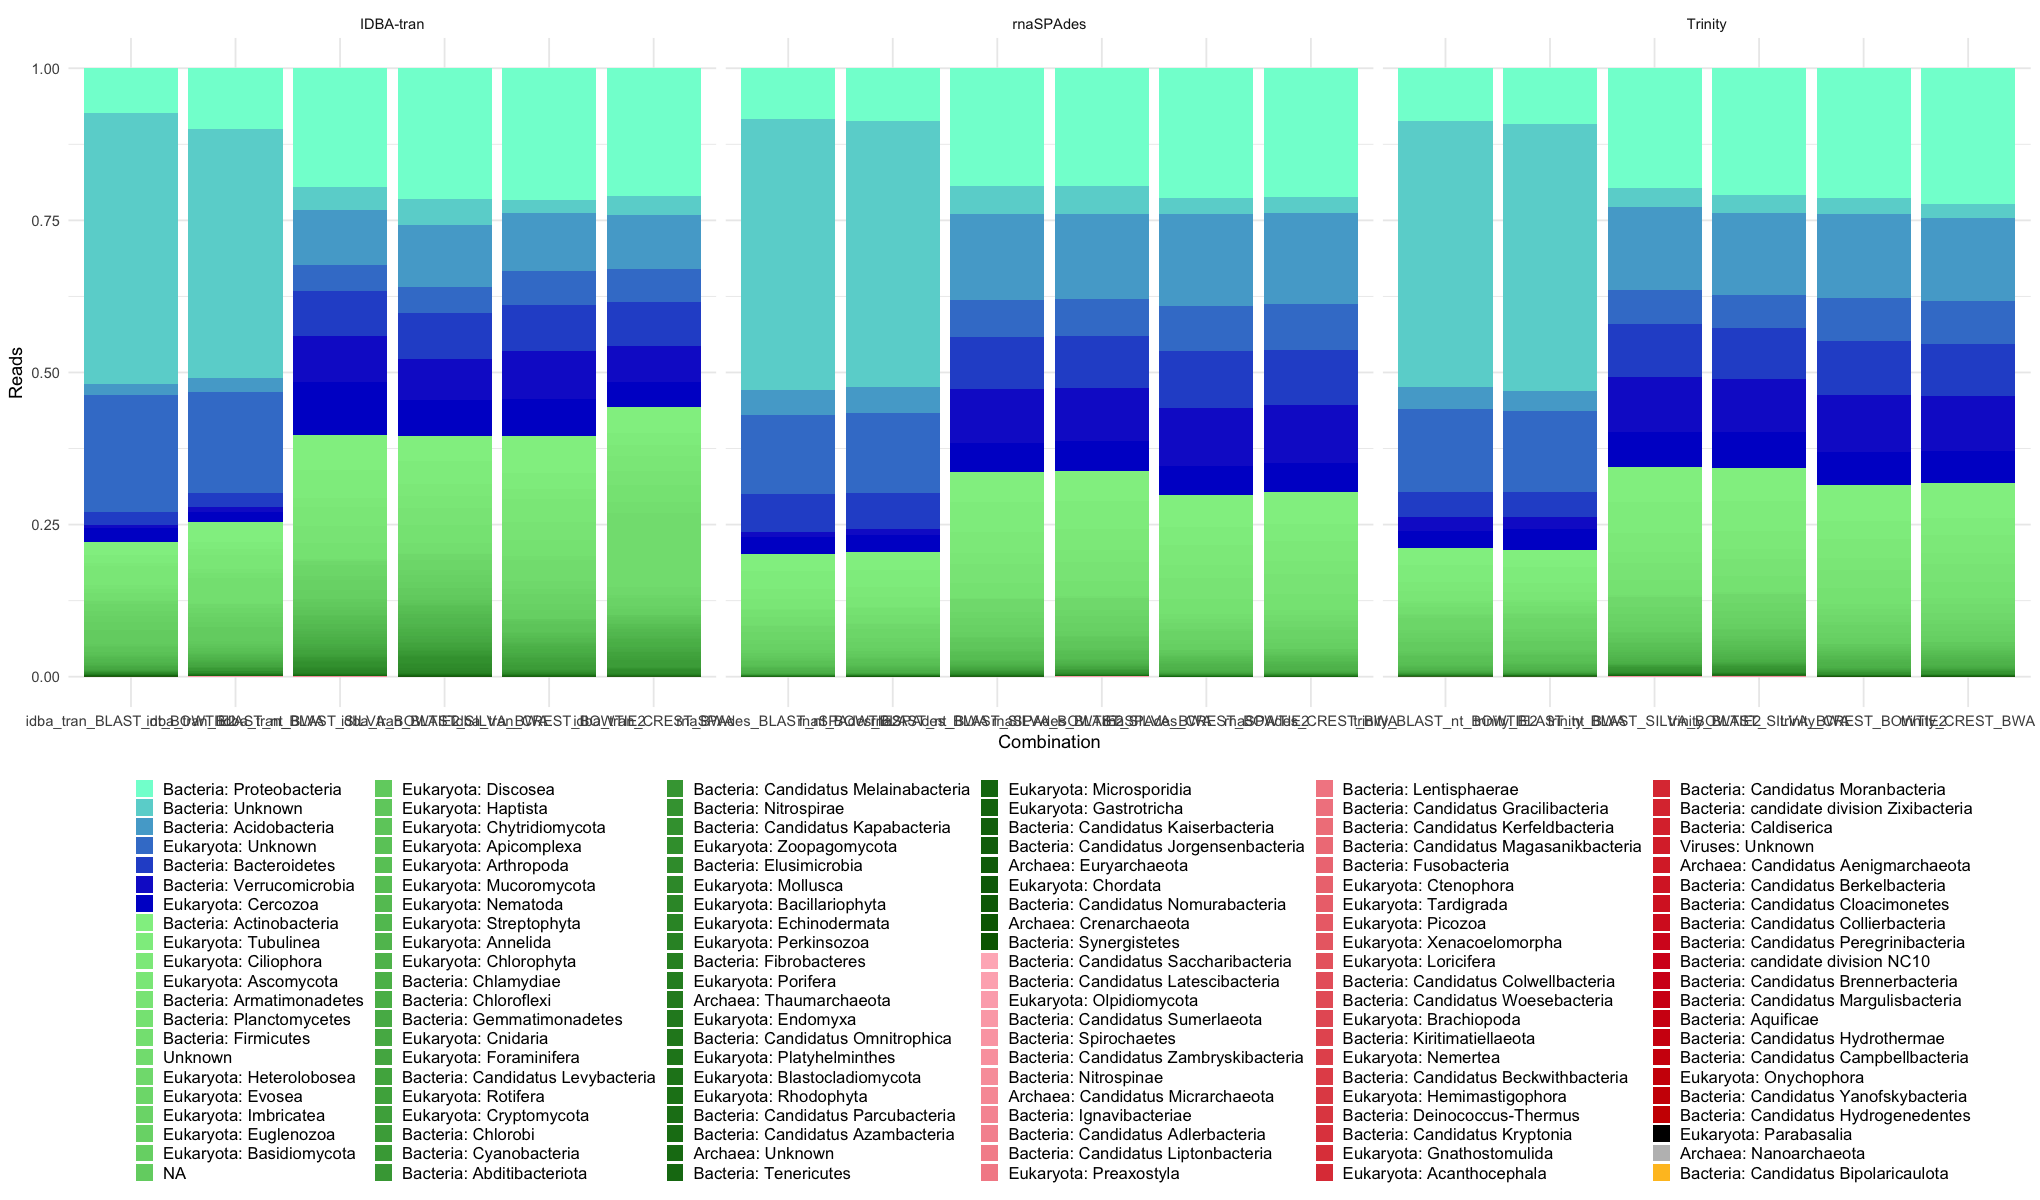

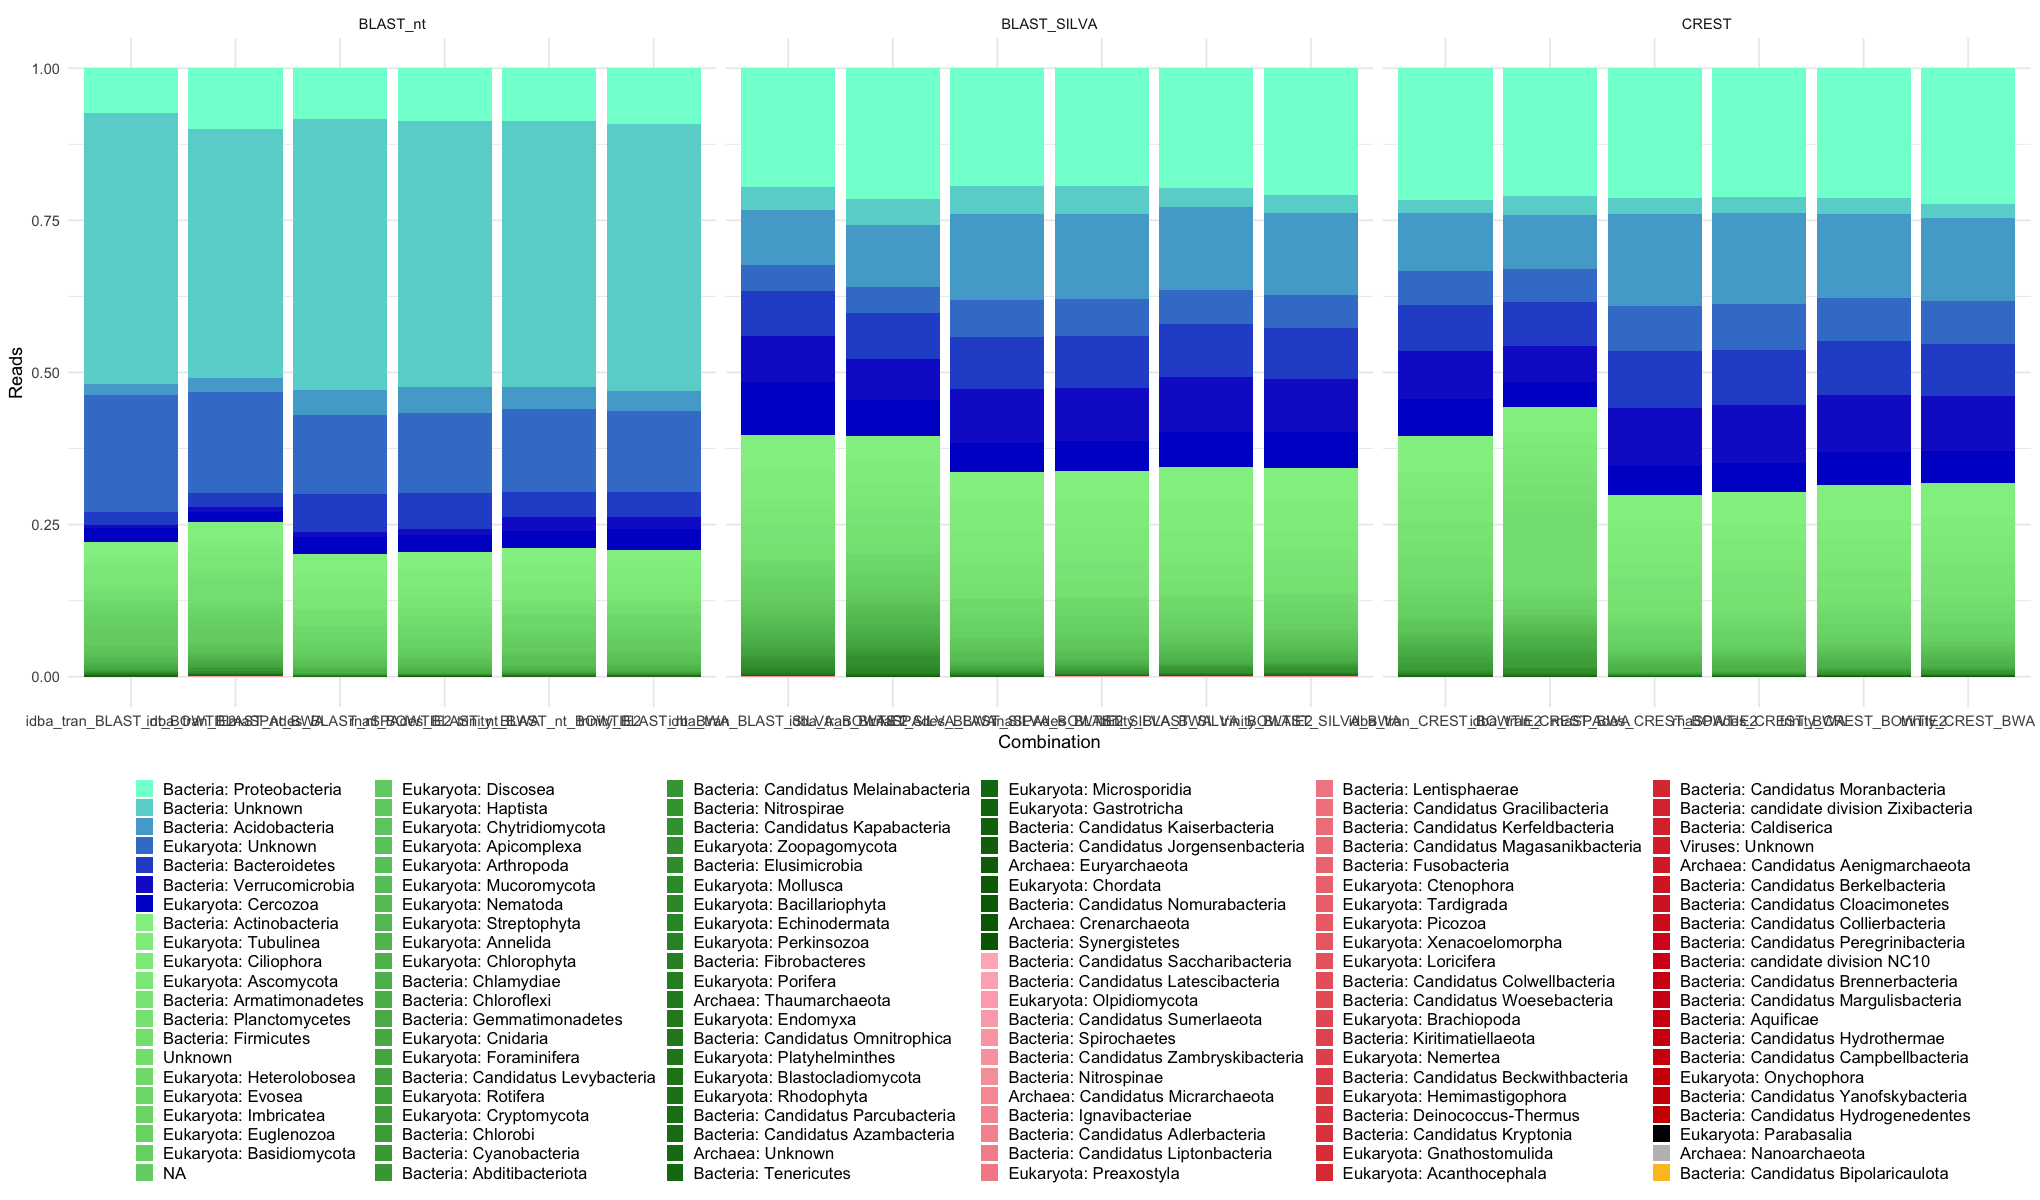

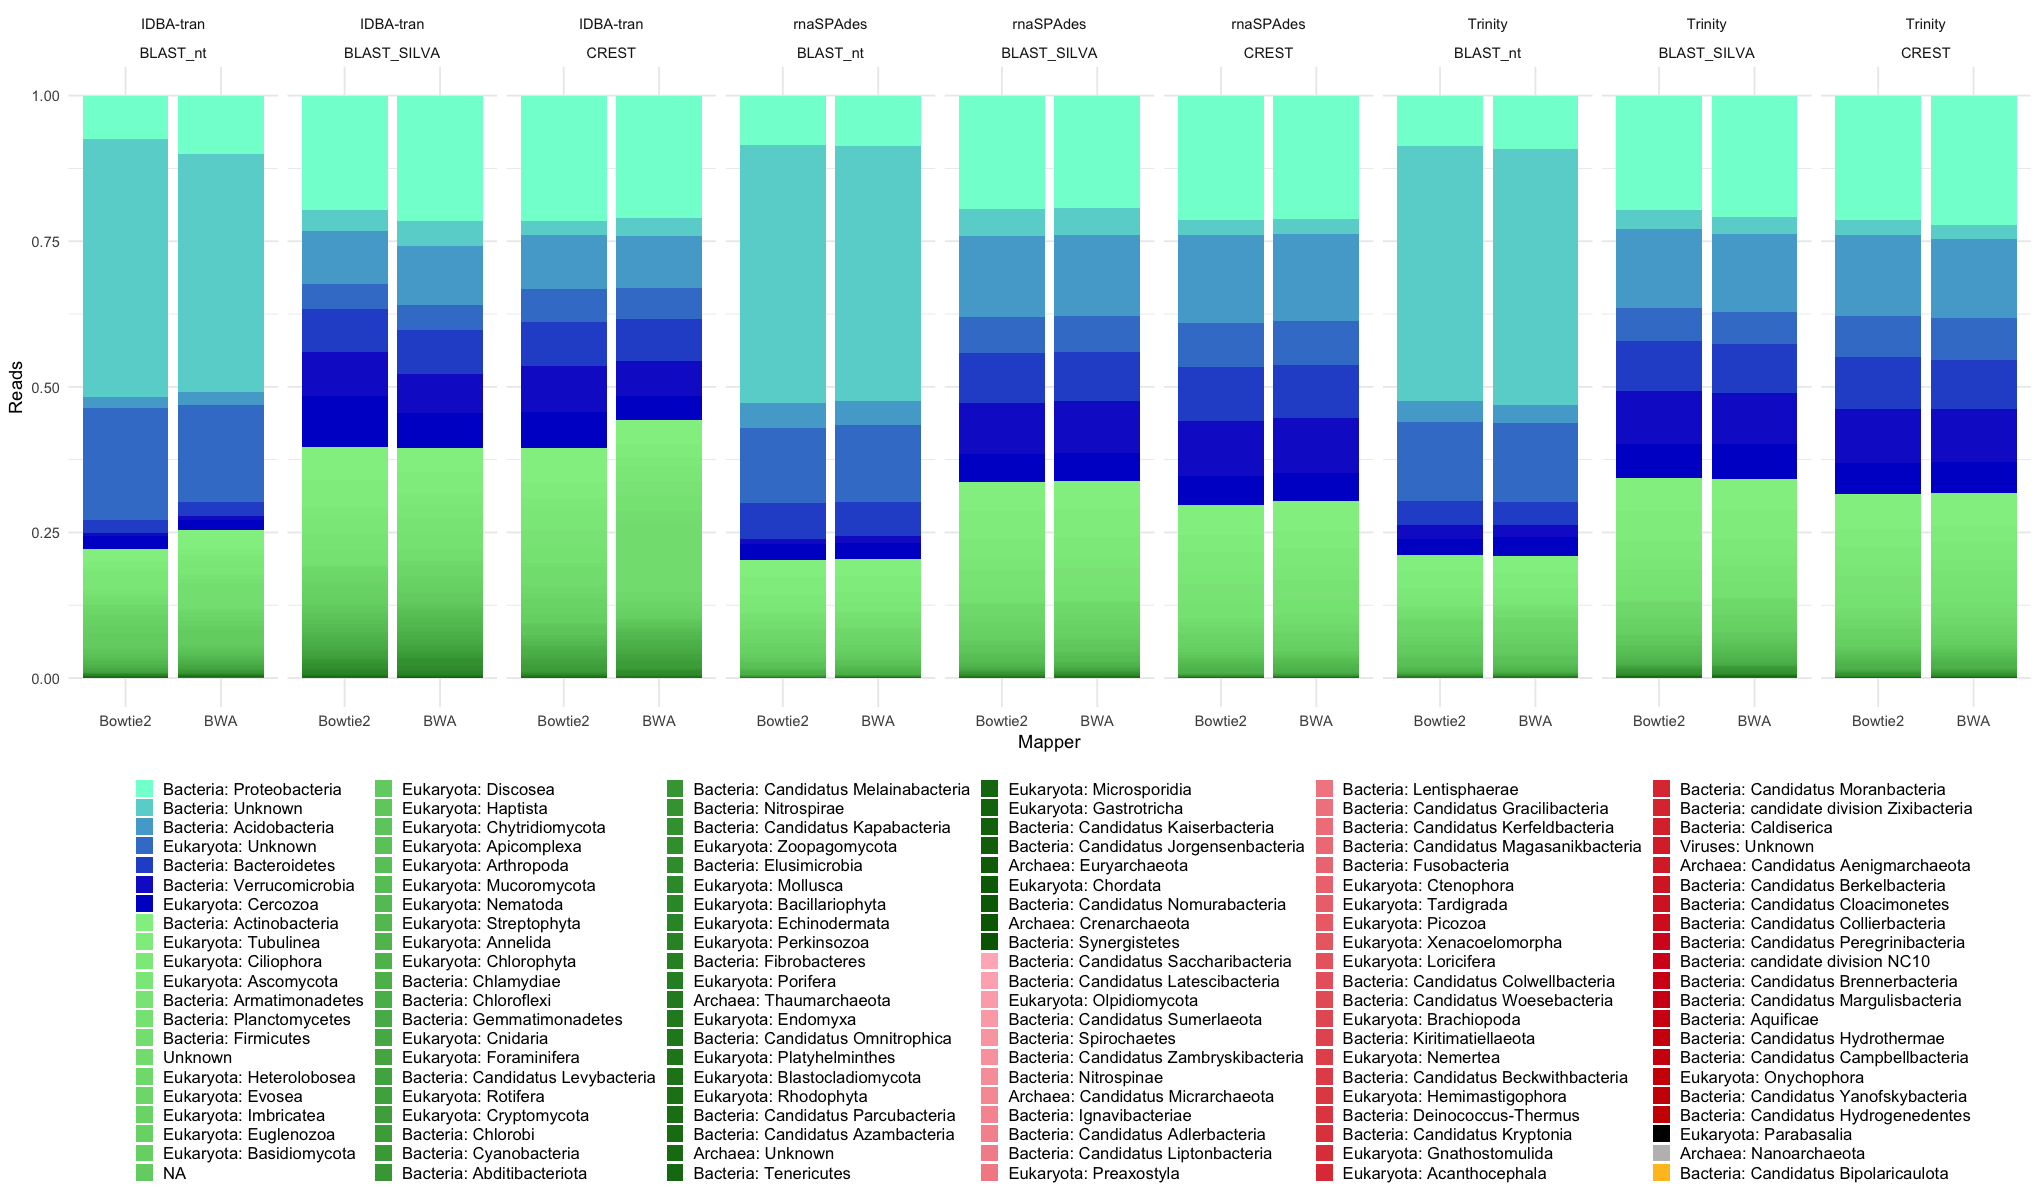

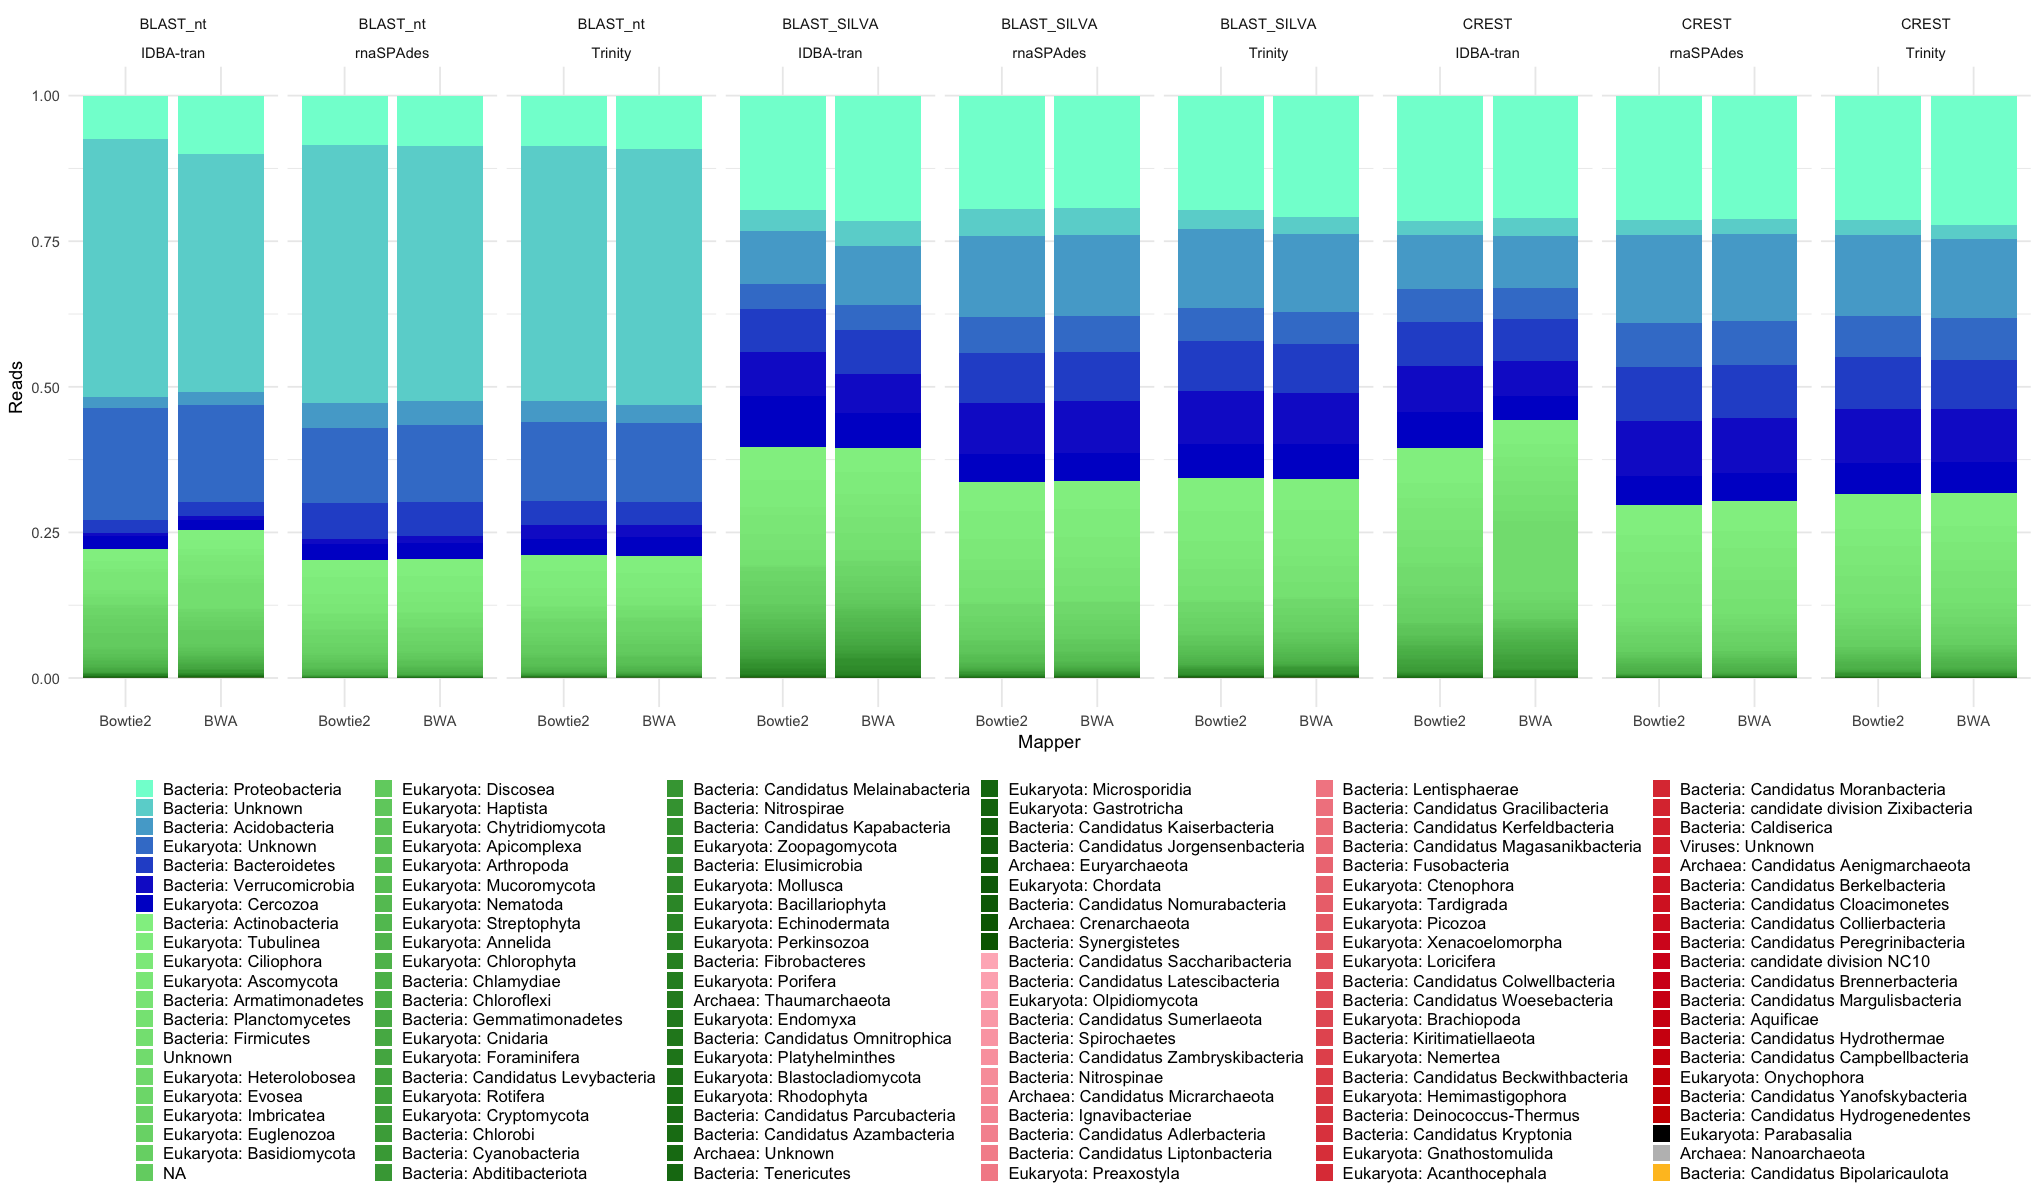

In [105]:
# Plot grouped by assembler
plot18<-ggplot(phylum_melted, aes(x = Combination, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Assembler, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec3_phylum_superkingdoms)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot18
#ggsave("Plot18.png", plot=plot18,  device="png",  width=240, units="mm")

# Plot grouped by classifier
plot19<-ggplot(phylum_melted, aes(x = Combination, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Classifier, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec3_phylum_superkingdoms)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot19
#ggsave("Plot19.png", plot=plot19,  device="png",  width=240, units="mm")

# Plot grouped by assembler and classifier
plot20<-ggplot(phylum_melted, aes(x = Mapper, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Assembler + Classifier, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec3_phylum_superkingdoms)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot20
#ggsave("Plot20.png", plot=plot20,  device="png",  width=240, units="mm")

# Plot grouped by classifier and assembler
plot21<-ggplot(phylum_melted, aes(x = Mapper, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Classifier + Assembler, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec3_phylum_superkingdoms)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot21
#ggsave("Plot21.png", plot=plot21,  device="png",  width=240, units="mm")

# 5. (NOT FINISHED) If you have too many groups or many groups with low abundance, these can be sorted out (= make a <u>subset</u> of groups with high enough abundance)

In [189]:
phylum_melted$Colour

[1] "#414487FF" "#440154FF" "#2A788EFF" "#414487FF" "#414487FF" "#2A788EFF"
   [7] "#414487FF" "#414487FF" "#414487FF" "#414487FF" "#414487FF" "#414487FF"
  [13] "#414487FF" "#414487FF" "#414487FF" "#414487FF" "#440154FF" "#FDE725FF"
  [19] "#414487FF" "#414487FF" "#414487FF" "#2A788EFF" "#2A788EFF" "#414487FF"
  [25] "#414487FF" "#2A788EFF" "#414487FF" "#2A788EFF" "#414487FF" "#2A788EFF"
  [31] "#414487FF" "#414487FF" "#2A788EFF" "#2A788EFF" "#2A788EFF" "#2A788EFF"
  [37] "#2A788EFF" "#414487FF" "#414487FF" "#414487FF" "#414487FF" "#414487FF"
  [43] "#2A788EFF" "#414487FF" "#414487FF" "#414487FF" "#440154FF" "#414487FF"
  [49] "#414487FF" "#414487FF" "#414487FF" "#2A788EFF" "#414487FF" "#414487FF"
  [55] "#414487FF" "#440154FF" "#414487FF" "#2A788EFF" "#440154FF" "#414487FF"
  [61] "#414487FF" "#2A788EFF" "#2A788EFF" "#414487FF" "#440154FF" "#414487FF"
  [67] "#414487FF" "#2A788EFF" "#2A788EFF" "#2A788EFF" "#414487FF" "#2A788EFF"
  [73] "#440154FF" "#2A788EFF" "#414487FF" "#2A788EFF" "#2A788EFF" "#2A788EFF"
  [79] "#2A788EFF" "#414487FF" "#2A788EFF" "#414487FF" "#414487FF" "#414487FF"
  [85] "#414487FF" "#414487FF" "#414487FF" "#2A788EFF" "#2A788EFF" "#414487FF"
  [91] "#2A788EFF" "#2A788EFF" "#414487FF" "#414487FF" "#414487FF" "#2A788EFF"
  [97] "#2A788EFF" "#2A788EFF" "#2A788EFF" "#2A788EFF" "#2A788EFF" "#2A788EFF"
 [103] "#2A788EFF" "#2A788EFF" "#2A788EFF" "#22A884FF" "#2A788EFF" "#2A788EFF"
 [109] "#2A788EFF" "#2A788EFF" "#2A788EFF" "#7AD151FF" "#414487FF" "#414487FF"
 [115] "#414487FF" "#2A788EFF" "#2A788EFF" "#2A788EFF" "#414487FF" "#2A788EFF"
 [121] "#414487FF" "#414487FF" "#2A788EFF" "#414487FF" "#414487FF" "#414487FF"
 [127] "#414487FF" "#440154FF" "#2A788EFF" "#414487FF" "#414487FF" "#2A788EFF"
 [133] "#414487FF" "#414487FF" "#414487FF" "#414487FF" "#414487FF" "#414487FF"
 [139] "#414487FF" "#414487FF" "#414487FF" "#414487FF" "#440154FF" "#FDE725FF"
 [145] "#414487FF" "#414487FF" "#414487FF" "#2A788EFF" "#2A788EFF" "#414487FF"
 [151] "#414487FF" "#2A788EFF" "#414487FF" "#2A788EFF" "#414487FF" "#2A788EFF"
 [157] "#414487FF" "#414487FF" "#2A788EFF" "#2A788EFF" "#2A788EFF" "#2A788EFF"
 [163] "#2A788EFF" "#414487FF" "#414487FF" "#414487FF" "#414487FF" "#414487FF"
 [169] "#2A788EFF" "#414487FF" "#414487FF" "#414487FF" "#440154FF" "#414487FF"
 [175] "#414487FF" "#414487FF" "#414487FF" "#2A788EFF" "#414487FF" "#414487FF"
 [181] "#414487FF" "#440154FF" "#414487FF" "#2A788EFF" "#440154FF" "#414487FF"
 [187] "#414487FF" "#2A788EFF" "#2A788EFF" "#414487FF" "#440154FF" "#414487FF"
 [193] "#414487FF" "#2A788EFF" "#2A788EFF" "#2A788EFF" "#414487FF" "#2A788EFF"
 [199] "#440154FF" "#2A788EFF" "#414487FF" "#2A788EFF" "#2A788EFF" "#2A788EFF"
 [205] "#2A788EFF" "#414487FF" "#2A788EFF" "#414487FF" "#414487FF" "#414487FF"
 [211] "#414487FF" "#414487FF" "#414487FF" "#2A788EFF" "#2A788EFF" "#414487FF"
 [217] "#2A788EFF" "#2A788EFF" "#414487FF" "#414487FF" "#414487FF" "#2A788EFF"
 [223] "#2A788EFF" "#2A788EFF" "#2A788EFF" "#2A788EFF" "#2A788EFF" "#2A788EFF"
 [229] "#2A788EFF" "#2A788EFF" "#2A788EFF" "#22A884FF" "#2A788EFF" "#2A788EFF"
 [235] "#2A788EFF" "#2A788EFF" "#2A788EFF" "#7AD151FF" "#414487FF" "#414487FF"
 [241] "#414487FF" "#2A788EFF" "#2A788EFF" "#2A788EFF" "#414487FF" "#2A788EFF"
 [247] "#414487FF" "#414487FF" "#2A788EFF" "#414487FF" "#414487FF" "#414487FF"
 [253] "#414487FF" "#440154FF" "#2A788EFF" "#414487FF" "#414487FF" "#2A788EFF"
 [259] "#414487FF" "#414487FF" "#414487FF" "#414487FF" "#414487FF" "#414487FF"
 [265] "#414487FF" "#414487FF" "#414487FF" "#414487FF" "#440154FF" "#FDE725FF"
 [271] "#414487FF" "#414487FF" "#414487FF" "#2A788EFF" "#2A788EFF" "#414487FF"
 [277] "#414487FF" "#2A788EFF" "#414487FF" "#2A788EFF" "#414487FF" "#2A788EFF"
 [283] "#414487FF" "#414487FF" "#2A788EFF" "#2A788EFF" "#2A788EFF" "#2A788EFF"
 [289] "#2A788EFF" "#414487FF" "#414487FF" "#414487FF" "#414487FF" "#414487FF"
 [295] "#2A788EFF" "#414487FF" "#414487FF" "#414487FF" "#440154FF" "#414487FF"
 [301] "#414487FF" "#414487FF" "#414487FF" "#2A788EFF

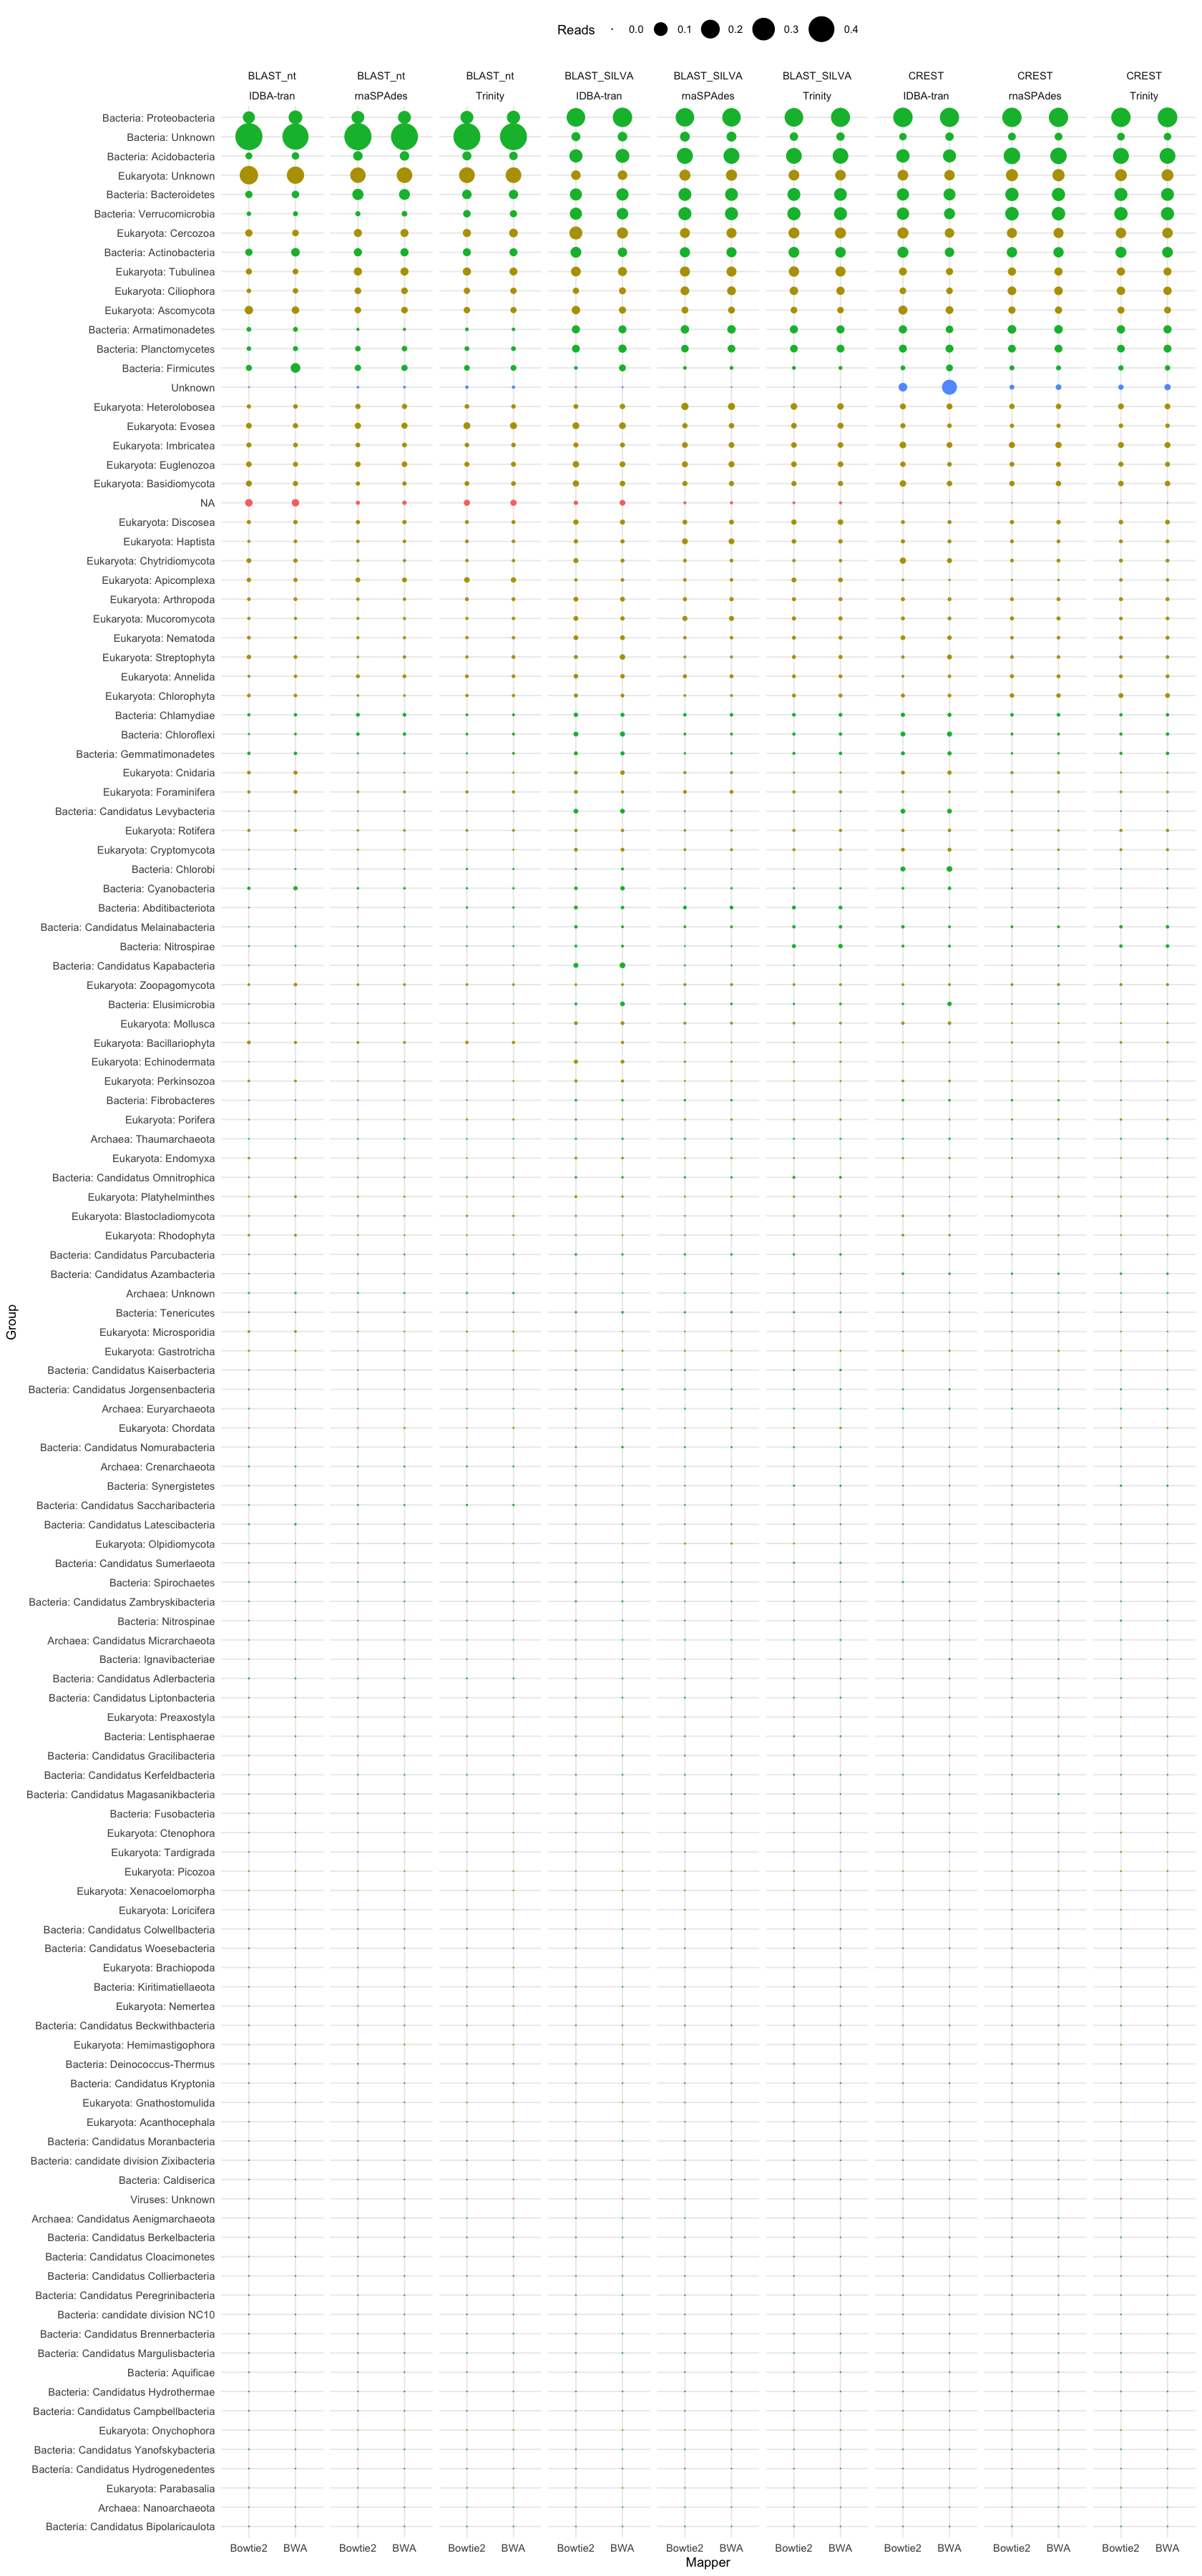

In [194]:
plot21<-ggplot(phylum_melted, aes(x=Mapper, y=Group, size=Reads))+
  geom_point(aes(color=Colour),alpha=1)+
  #geom_point(alpha=1)+
  facet_grid( ~ Classifier + Assembler, scales = "free", space = "free")+
  theme_minimal()+
  #scale_color_manual(values=colorvec3_phylum_superkingdoms) +
  theme(legend.position="top")+
  guides(color = FALSE, fill=guide_legend(ncol=6,byrow=FALSE))+
  scale_size(range = c(0, 10))
  #theme(axis.text.y = element_text(colour=phylum_melted$Colour))
options(repr.plot.width=14, repr.plot.height=30)
plot21

In [23]:
# Subsetting merged_ordered for PHYLUM that are of low abundance (rowSums < abundance)
phylum_groupabundance <- rowSums(select(merged_phylum_ordered, -Group))
merged_phylum_ordered_groupabundance <- data.frame(merged_phylum_ordered$Group, phylum_groupabundance)
merged_phylum_ordered_groupabundance <- merged_phylum_ordered_groupabundance[order(merged_phylum_ordered_groupabundance[[2]], decreasing=TRUE),]
merged_phylum_ordered_groupabundance # Inspect dataframe to see what minimum group abundance makes sense/if any makes sense
# Uncomment the following if you can't see enough in the displayed dataframe due to its size
#as.vector(phylum_groupabundance[order(phylum_groupabundance, decreasing=TRUE)])

minimum_group_abundance <- 100 # Set minimum group abundance
merged_phylum_ordered_subset <- merged_phylum_ordered
rownames(merged_phylum_ordered_subset) <- merged_phylum_ordered_subset$Group
merged_phylum_ordered_subset$Group <- NULL
merged_phylum_ordered_subset <- subset(merged_phylum_ordered_subset, rowSums(merged_phylum_ordered_subset) >= minimum_group_abundance)


merged_phylum_ordered.Group               phylum_groupabundance
29  Bacteria: Unknown                         81302377             
25  Bacteria: Proteobacteria                  78277940             
5   Bacteria: Acidobacteria                   44532658             
64  Eukaryota: Unknown                        42365199             
8   Bacteria: Bacteroidetes                   32598533             
30  Bacteria: Verrucomicrobia                 27988596             
38  Eukaryota: Cercozoa                       20753001             
6   Bacteria: Actinobacteria                  20518899             
63  Eukaryota: Tubulinea                      15191210             
41  Eukaryota: Ciliophora                     10876481             
7   Bacteria: Armatimonadetes                  9569370             
34  Eukaryota: Ascomycota                      9471092             
24  Bacteria: Planctomycetes                   9347107             
20  Bacteria: Firmicutes                       5695403             
68  Unknown                                    5387557             
51  Eukaryota: Heterolobosea                   5284850             
47  Eukaryota: Evosea                          5144506             
52  Eukaryota: Imbricatea                      4616801             
46  Eukaryota: Euglenozoa                      4462771             
36  Eukaryota: Basidiomycota                   4085989             
67  NA                                         2747987             
44  Eukaryota: Discosea                        2742911             
50  Eukaryota: Haptista                        2083794             
32  Eukaryota: Apicomplexa                     1952536             
54  Eukaryota: Mucoromycota                    1756834             
33  Eukaryota: Arthropoda                      1756153             
40  Eukaryota: Chytridiomycota                 1716102             
31  Eukaryota: Annelida                        1572726             
62  Eukaryota: Streptophyta                    1572205             
55  Eukaryota: Nematoda                        1516411             
⋮   ⋮                                         ⋮                    
121 Eukaryota: Brachiopoda                    606                  
109 Eukaryota: Hemimastigophora               492                  
99  Bacteria: Kiritimatiellaeota              488                  
115 Bacteria: Candidatus Beckwithbacteria     472                  
19  Bacteria: Deinococcus-Thermus             448                  
105 Eukaryota: Nemertea                       426                  
118 Bacteria: Candidatus Kryptonia            322                  
108 Eukaryota: Gnathostomulida                314                  
101 Eukaryota: Acanthocephala                 293                  
114 Bacteria: candidate division Zixibacteria 234                  
88  Bacteria: Candidatus Moranbacteria        215                  
112 Viruses: Unknown                          194                  
113 Bacteria: Caldiserica                     178                  
74  Bacteria: Candidatus Berkelbacteria       131                  
125 Bacteria: Candidatus Cloacimonetes        130                  
69  Archaea: Candidatus Aenigmarchaeota       116                  
76  Bacteria: Candidatus Collierbacteria      104                  
91  Bacteria: Candidatus Peregrinibacteria     84                  
9   Bacteria: candidate division NC10          79                  
75  Bacteria: Candidatus Brennerbacteria       77                  
86  Bacteria: Candidatus Margulisbacteria      65                  
72  Bacteria: Aquificae                        47                  
79  Bacteria: Candidatus Hydrothermae          45                  
11  Bacteria: Candidatus Campbellbacteria      44                  
122 Eukaryota: Onychophora                     42                  
117 Bacteria: Candidatus Hydrogenedentes       21                  
93  Bacteria: Candidatus Yanofskybacteria      15           